<a id="title_ID"></a>
# JWST Pipeline Validation Testing Notebook: Calwebb_Image3, Tweakreg step with MIRI imaging

<span style="color:red"> **Instruments Affected**</span>: FGS, MIRI, NIRCam, NIRISS 

Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Run JWST Pipelines](#pipeline_ID) <br> [Imports](#imports_ID) <br> [Create an association table for your cal files and run them through calwebb_image3](#runpipeline_ID) <br> [Find Stars in Image and Determine their Coordinates](#runscript_ID) <br> [Compare RA and Dec to expected Values](#residual_ID) <br> [About This Notebook](#about_ID) <br>


</div>

<a id="intro_ID"></a>
# Introduction


This test is designed to test the tweakreg step in the calwebb_image3 pipeline. At the start of the calwebb_image3 pipeline, the shifts between the images in an association table are found. This step creates image catalogs of point-like sources whose centroids are then used to compute corrections to the WCS of the input images such that sky catalogs obtained from the image catalogs using the corrected WCS will align on the sky.

For more information on the pipeline step visit the links below. 

Step description: https://jwst-pipeline.readthedocs.io/en/latest/jwst/tweakreg/README.html

Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/tweakreg

The data for this test were created with the MIRI Data Simulator, and the documentation for that code can be found here: http://miri.ster.kuleuven.be/bin/view/Public/MIRISim_Public


### Calibration WG Requested Algorithm: 

A short description and link to the page: https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Refine+WCS


### Defining Terms
Definition of terms or acronymns.

JWST: James Webb Space Telescope

MIRI: Mid-Infrared Instrument

MIRISim: MIRI Data Simulator

### Description of test

This test is performed by creating a set of simulated data with multiple point sources located at specified coordinates. The simulator puts in the expected distortion, so the initial output data comes out of the simulator in distorted coordinates. When this data is then run through calwebb_detector1, calwebb_image2 and calwebbb_image3, the combined, undistorted image should have the point sources registered at the expected locations. In flight, this test can be repeated with known stars that should be found at their expected coordinates. If there is a shift in coordinates between the images that was not expected, tweakreg will find the sources to create a better image alignment. This is checked by using DAOStarFinder to find the point sources in each image (individual and combined) so that the catalogs can be compared to the expected RA and Dec values that were used to create the images. The user will look at whether the statistics of the combined sources are better or worse than those of the individual images.

### Description of data

The data used in this simulation were created with the MIRISim simulator.

The simulation consists of eight files, two exposures each at four different dither positions. The images used in this test have 50 bright point sources scattered across the images, and were created in the F1130W filter.



[Top of Page](#title_ID)

In [1]:
# set up import statements
from astropy.io import ascii, fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Column
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.table import Table
import astropy.units as u
from astropy.coordinates import SkyCoord, match_coordinates_sky

#from ci_watson.artifactory_helpers import get_bigdata
import glob
from itertools import product
from ci_watson.artifactory_helpers import get_bigdata

# Box download imports 
from astropy.utils.data import download_file
from pathlib import Path
from shutil import move
from os.path import splitext

from jwst.datamodels import DrizProductModel, ImageModel
from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list

import math
import matplotlib.pyplot as plt
import numpy as np
import os
from photutils import CircularAperture, DAOStarFinder, CircularAnnulus, aperture_photometry

### Create a temporary directory to work in and read in data

In [2]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)
print(data_dir)

<TemporaryDirectory '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l'>


In [3]:
#print("Downloading input files")
 
#This readnoise file is needed for use with simulated data which has higher readnoise than actual data.
#readnoise = get_bigdata('jwst_validation_notebooks',
#                     'validation_data',
#                     'jump',                     
#                     'jump_miri_test', 
#                     'jwst_mirisim_readnoise.fits')

#filelist = ['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 
#            'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2.fits',
#            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',
#            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2.fits',
#            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',
#            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2.fits',
#            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',
#            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2.fits']

#for file in filelist:
#    input_file = get_bigdata('jwst_validation_notebooks',
#                     'validation_data',
#                     'outlier_detection',
#                     'outlier_detection_miri_test',
#                     file)
    
#coords = get_bigdata('jwst_validation_notebooks',
#                     'validation_data',
#                     'resample',
#                     'resample_miri_test', 
#                     'radec_4ptdith_50star_mosaic_coords.txt')    

#print("Finished Downloads")


In [4]:
# Read rate files in from Box rather than starting with uncal and running through calwebb_detector1

def get_box_files(file_list):
    for box_url,file_name in file_list:
        if 'https' not in box_url:
            box_url = 'https://stsci.box.com/shared/static/' + box_url
        downloaded_file = download_file(box_url)
        if Path(file_name).suffix == '':
            ext = splitext(box_url)[1]
            file_name += ext
        move(downloaded_file, file_name)

        
file_urls = ['https://stsci.box.com/shared/static/46kwitm6fswmeiuw4gu6xxgeioy7dhca.fits',
             'https://stsci.box.com/shared/static/8vs4njvio6y15cdcl3rjtb4veb55h6o9.fits',
             'https://stsci.box.com/shared/static/09xjv0lpe35o50f2xf4ydu523g03s9fd.fits',
             'https://stsci.box.com/shared/static/tqay5edhq1hstayk897ugd8t5sjbbjme.fits',
             'https://stsci.box.com/shared/static/rmri5jb6gwpezva2rgzkkguoeos7nocv.fits',
             'https://stsci.box.com/shared/static/pdtjm55j5ahj08i1rm91jw5p2ijpvi68.fits',
             'https://stsci.box.com/shared/static/bw5jsrorue4g2eprpd06w8sdvy6etqhv.fits',
             'https://stsci.box.com/shared/static/y3thiqwcyihw30vndpy16o8bjxn36o89.fits',
             'https://stsci.box.com/shared/static/u2wc9ocug98ut8arz383oid0eru06qbo.txt']
    
file_names = ['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits', 
            'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits',
            'radec_4ptdith_50star_mosaic_coords.txt']

    
box_download_list = [(url,name) for url,name in zip(file_urls,file_names)]


get_box_files(box_download_list)
    

In [5]:
coords = 'radec_4ptdith_50star_mosaic_coords.txt'

### Run the calwebb_detector1 pipeline to get rate.fits files.

In [6]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters 
#rej_thresh=10.0  # rejection threshold for jump step

#print('There are ', len(filelist), ' images.')
    
#slopelist = []    
    
# loop over list of files
#for file in filelist:
       
    # set up pipeline parameters for input
#    pipe1 = Detector1Pipeline()
#    pipe1.jump.rejection_threshold = rej_thresh
#    pipe1.jump.override_readnoise = readnoise
#    pipe1.ramp_fit.override_readnoise = readnoise

#    pipe1.refpix.skip = True  # needs update to simulator for this to work properly with simulated data
        
    # set up output file name
#    base, remainder = file.split('.')
#    outname = base
        
#    pipe1.jump.output_file = outname+'.fits'    
    #pipe1.ramp_fit.output_file = outname+'.fits'
#    pipe1.output_file = outname+'.fits'

    # Run pipeline on each file
#    rampfile = pipe1.run(file)
#    slopelist.append(rampfile)
    
    # Close the input files
    #file.close()

#print('Detector 1 steps completed on all files.')
#print(slopelist)

In [7]:
slopelist = ['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits', 
            'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits',
            'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits',
            'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits',
            'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits']

### Run calwebb_image2 pipeline to create cal.fits files

In [8]:
# Run Calwebb_image2 on output files from detector1
    
print('There are ', len(slopelist), ' images.')

callist = []
ratefilenames = []

# cycle through files
for file in slopelist:
    rampfile = ImageModel(file)
    
    # create an object for the pipeline    
    pipe2 = Image2Pipeline()
    
    filename = rampfile.meta.filename
    ratefilenames.append(filename)
    # Set pipeline parameters

    pipe2.save_results = True
    pipe2.output_file = filename +'_cal.fits'
    pipe2.resample.save_results = True
    pipe2.suffix = None

    calfile = pipe2.run(rampfile)

    callist.append(calfile)

print(callist)

There are  8  images.


2021-08-28 02:18:25,972 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:18:25,974 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:18:25,976 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:18:25,977 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:18:25,978 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:18:25,979 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:18:26,108 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:26,113 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:18:26,121 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:18:26,307 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:18:26,308 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:18:26,309 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:18:26,309 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:18:26,310 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:18:26,310 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:18:26,311 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:18:26,312 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:18:26,313 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:18:26,314 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:18:26,315 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:18:26,316 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:18:26,316 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:18:26,317 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:18:26,317 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:18:26,317 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:18:26,317 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:18:26,318 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:18:26,319 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:18:26,319 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:18:26,320 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:18:26,320 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:18:26,320 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:18:26,321 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:18:26,374 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:18:26,375 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-08-28 02:18:26,508 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:26,510 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:18:26,691 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:18:26,753 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-08-28 02:18:26,753 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-08-28 02:18:26,753 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:18:26,784 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:18:26,833 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:18:26,962 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:26,964 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:18:27,068 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:27,069 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:27,070 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:27,076 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:27,186 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:18:27,323 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:27,325 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:18:27,348 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:18:27,348 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:18:27,410 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:18:27,410 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:18:27,410 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:18:27,411 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:18:27,444 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:18:27,445 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:18:27,446 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:18:27,456 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:18:27,576 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:27,578 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:18:27,600 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:18:27,696 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:18:28,295 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:28,702 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:18:29,272 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:29,685 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:18:30,212 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:30,622 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:18:31,167 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:31,587 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:31,589 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019358646 -0.016334386 0.022108876 0.015005126 359.990738698 0.017758047 359.987988468 -0.013581465


2021-08-28 02:18:31,695 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits


2021-08-28 02:18:31,696 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:18:31,697 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:18:31,699 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:18:31,828 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits


2021-08-28 02:18:31,829 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-08-28 02:18:31,864 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:18:31,866 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:18:31,867 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:18:31,869 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:18:31,870 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:18:31,872 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:18:32,042 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:32,046 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:18:32,053 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:18:32,057 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:18:32,059 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:18:32,059 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:18:32,059 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:18:32,060 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:18:32,060 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:18:32,061 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:18:32,062 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:18:32,062 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:18:32,063 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:18:32,064 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:18:32,064 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:18:32,064 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:18:32,065 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:18:32,065 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:18:32,065 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:18:32,066 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:18:32,066 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:18:32,067 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:18:32,067 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:18:32,068 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:18:32,068 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:18:32,068 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:18:32,069 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:18:32,120 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:18:32,120 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-08-28 02:18:32,268 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:32,270 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:18:32,437 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:18:32,495 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:32,499 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-08-28 02:18:32,500 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019410529 -0.016138544 0.021878136 0.015048625 359.990819026 0.017621279 359.988011958 -0.013579591


2021-08-28 02:18:32,500 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:18:32,536 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:18:32,585 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:18:32,723 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:32,724 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:18:32,827 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:32,829 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:32,841 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:32,848 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:32,962 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:18:33,107 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:33,109 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:18:33,133 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:18:33,134 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:18:33,205 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:18:33,205 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:18:33,206 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:18:33,206 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:18:33,237 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:18:33,240 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:18:33,240 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:18:33,251 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:18:33,378 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:33,379 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:18:33,402 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:18:33,503 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:18:34,093 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:34,505 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:18:35,044 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:35,485 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:18:36,175 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:36,600 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:18:37,278 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:37,711 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:37,713 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019358646 -0.016334386 0.022108876 0.015005126 359.990738698 0.017758047 359.987988468 -0.013581465


2021-08-28 02:18:37,811 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_i2d.fits


2021-08-28 02:18:37,812 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:18:37,812 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:18:37,814 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:18:37,950 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits


2021-08-28 02:18:37,951 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-08-28 02:18:37,984 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:18:37,985 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:18:37,987 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:18:37,988 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:18:37,989 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:18:37,990 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:18:38,137 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:38,142 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:18:38,149 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:18:38,153 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:18:38,155 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:18:38,156 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:18:38,156 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:18:38,156 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:18:38,157 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:18:38,158 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:18:38,159 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:18:38,159 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:18:38,160 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:18:38,161 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:18:38,161 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:18:38,162 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:18:38,162 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:18:38,162 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:18:38,163 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:18:38,163 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:18:38,163 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:18:38,164 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:18:38,164 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:18:38,165 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:18:38,165 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:18:38,166 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:18:38,166 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:18:38,213 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:18:38,214 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-08-28 02:18:38,362 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:38,364 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:18:38,529 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:18:38,582 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:38,586 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-08-28 02:18:38,586 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-08-28 02:18:38,586 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:18:38,618 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:18:38,666 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:18:38,845 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:38,847 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:18:38,955 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:38,955 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:38,956 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:38,963 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:39,073 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:18:39,212 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:39,213 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:18:39,237 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:18:39,238 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:18:39,305 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:18:39,306 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:18:39,306 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:18:39,307 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:18:39,337 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:18:39,338 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:18:39,339 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:18:39,350 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:18:39,492 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:39,494 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:18:39,517 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:18:39,619 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:18:40,199 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:40,611 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:18:41,220 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:41,634 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:18:42,291 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:42,700 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:18:43,352 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:43,776 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:43,778 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019997794 -0.017656179 0.022748024 0.013683333 359.991377847 0.016436254 359.988627617 -0.014903258


2021-08-28 02:18:43,881 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits


2021-08-28 02:18:43,882 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:18:43,883 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:18:43,884 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:18:44,016 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits


2021-08-28 02:18:44,017 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-08-28 02:18:44,047 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:18:44,048 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:18:44,050 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:18:44,051 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:18:44,052 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:18:44,053 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:18:44,199 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:44,203 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:18:44,210 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:18:44,218 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:18:44,219 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:18:44,219 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:18:44,219 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:18:44,219 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:18:44,220 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:18:44,220 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:18:44,221 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:18:44,221 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:18:44,222 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:18:44,223 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:18:44,223 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:18:44,223 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:18:44,223 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:18:44,224 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:18:44,224 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:18:44,224 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:18:44,224 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:18:44,225 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:18:44,225 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:18:44,226 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:18:44,226 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:18:44,226 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:18:44,227 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:18:44,270 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:18:44,271 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-08-28 02:18:44,444 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:44,446 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:18:44,615 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:18:44,678 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:44,682 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-08-28 02:18:44,682 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020049678 -0.017460337 0.022517284 0.013726832 359.991458175 0.016299486 359.988651107 -0.014901383


2021-08-28 02:18:44,683 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:18:44,714 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:18:44,761 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:18:44,893 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:44,894 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:18:45,005 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:45,006 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:45,006 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:45,014 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:45,120 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:18:45,254 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:45,255 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:18:45,278 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:18:45,279 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:18:45,343 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:18:45,343 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:18:45,344 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:18:45,344 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:18:45,373 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:18:45,374 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:18:45,375 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:18:45,385 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:18:45,517 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:45,519 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:18:45,541 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:18:45,638 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:18:46,212 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:46,628 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:18:47,178 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:47,595 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:18:48,144 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:48,565 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:18:49,116 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:49,543 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:49,546 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019997794 -0.017656179 0.022748024 0.013683333 359.991377847 0.016436254 359.988627617 -0.014903258


2021-08-28 02:18:49,649 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits


2021-08-28 02:18:49,650 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:18:49,650 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:18:49,652 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:18:49,788 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits


2021-08-28 02:18:49,789 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-08-28 02:18:49,822 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:18:49,823 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:18:49,825 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:18:49,826 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:18:49,827 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:18:49,828 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:18:49,983 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:49,988 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:18:49,995 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:18:49,999 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:18:50,000 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:18:50,001 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:18:50,001 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:18:50,001 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:18:50,002 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:18:50,002 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:18:50,003 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:18:50,004 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:18:50,005 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:18:50,005 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:18:50,006 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:18:50,006 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:18:50,006 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:18:50,007 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:18:50,007 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:18:50,007 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:18:50,008 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:18:50,008 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:18:50,009 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:18:50,009 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:18:50,010 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:18:50,010 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:18:50,011 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:18:50,055 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:18:50,056 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-08-28 02:18:50,197 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:50,198 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:18:50,368 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:18:50,421 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:50,426 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-08-28 02:18:50,426 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-08-28 02:18:50,427 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:18:50,459 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:18:50,510 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:18:50,655 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:50,657 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:18:50,754 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:50,755 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:50,756 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:50,763 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:50,875 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:18:51,011 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:51,012 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:18:51,036 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:18:51,036 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:18:51,104 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:18:51,105 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:18:51,105 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:18:51,105 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:18:51,137 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:18:51,138 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:18:51,139 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:18:51,149 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:18:51,314 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:18:51,316 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:18:51,339 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:18:51,438 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:18:52,008 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:52,419 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:18:52,963 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:53,380 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:18:53,936 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:54,357 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:18:54,915 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:55,339 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:55,341 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020228939 -0.020106952 0.022979169 0.011232559 359.991608992 0.013985480 359.988858761 -0.017354031


2021-08-28 02:18:55,437 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits


2021-08-28 02:18:55,437 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:18:55,438 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:18:55,439 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:18:55,570 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits


2021-08-28 02:18:55,571 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-08-28 02:18:55,604 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:18:55,606 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:18:55,607 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:18:55,608 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:18:55,609 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:18:55,611 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:18:55,750 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:55,754 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:18:55,761 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:18:55,765 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:18:55,767 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:18:55,767 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:18:55,768 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:18:55,768 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:18:55,768 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:18:55,769 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:18:55,770 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:18:55,771 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:18:55,771 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:18:55,772 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:18:55,772 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:18:55,773 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:18:55,773 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:18:55,773 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:18:55,774 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:18:55,774 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:18:55,775 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:18:55,776 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:18:55,776 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:18:55,776 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:18:55,777 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:18:55,777 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:18:55,777 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:18:55,828 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:18:55,829 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-08-28 02:18:55,932 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:55,933 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:18:56,104 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:18:56,156 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:18:56,159 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-08-28 02:18:56,160 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020280823 -0.019911110 0.022748429 0.011276059 359.991689320 0.013848713 359.988882252 -0.017352157


2021-08-28 02:18:56,160 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:18:56,191 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:18:56,240 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:18:56,342 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:56,344 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:18:56,439 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:56,440 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:56,440 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:56,447 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:18:56,552 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:18:56,652 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:56,654 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:18:56,677 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:18:56,677 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:18:56,741 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:18:56,742 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:18:56,742 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:18:56,743 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:18:56,772 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:18:56,773 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:18:56,774 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:18:56,784 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:18:56,882 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:18:56,883 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:18:56,906 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:18:57,002 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:18:57,576 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:57,991 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:18:58,545 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:58,963 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:18:59,513 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:18:59,933 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:19:00,474 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:00,899 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:19:00,901 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020228939 -0.020106952 0.022979169 0.011232559 359.991608992 0.013985480 359.988858761 -0.017354031


2021-08-28 02:19:01,000 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_i2d.fits


2021-08-28 02:19:01,001 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:19:01,002 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:19:01,003 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:19:01,131 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits


2021-08-28 02:19:01,131 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-08-28 02:19:01,163 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:19:01,164 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:19:01,165 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:19:01,167 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:19:01,168 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:19:01,169 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:19:01,290 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:19:01,294 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:19:01,301 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:19:01,304 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:19:01,306 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:19:01,306 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:19:01,307 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:19:01,307 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:19:01,307 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:19:01,308 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:19:01,309 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:19:01,310 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:19:01,310 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:19:01,311 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:19:01,312 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:19:01,312 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:19:01,312 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:19:01,312 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:19:01,313 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:19:01,313 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:19:01,314 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:19:01,314 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:19:01,315 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:19:01,315 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:19:01,315 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:19:01,316 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:19:01,316 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:19:01,357 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:19:01,357 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits> ...


2021-08-28 02:19:01,456 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:19:01,458 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:19:01,618 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:19:01,667 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:19:01,670 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-08-28 02:19:01,671 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-08-28 02:19:01,671 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:19:01,702 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:19:01,748 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:19:01,843 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:19:01,844 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:19:01,937 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:01,938 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:01,938 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:01,945 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:02,047 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:19:02,153 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:19:02,154 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:19:02,177 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:19:02,177 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:19:02,242 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:19:02,242 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:19:02,243 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:19:02,243 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:19:02,273 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:19:02,275 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:19:02,276 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:19:02,286 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:19:02,381 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2021-08-28 02:19:02,382 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:19:02,405 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:19:02,501 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:19:03,069 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:03,484 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:19:04,029 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:04,435 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:19:04,977 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:05,396 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:19:05,928 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:06,345 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:19:06,347 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021764821 -0.019608104 0.024515051 0.011731407 359.993144874 0.014484328 359.990394643 -0.016855183


2021-08-28 02:19:06,440 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits


2021-08-28 02:19:06,440 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:19:06,441 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2021-08-28 02:19:06,442 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:19:06,565 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits


2021-08-28 02:19:06,566 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2021-08-28 02:19:06,596 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:19:06,597 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:19:06,599 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:19:06,600 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:19:06,601 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:19:06,603 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:19:06,708 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:19:06,713 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model

2021-08-28 02:19:06,719 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:19:06,722 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:19:06,724 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:19:06,725 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:19:06,725 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:19:06,725 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:19:06,725 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:19:06,726 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:19:06,727 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:19:06,727 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:19:06,728 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:19:06,729 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:19:06,729 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:19:06,730 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:19:06,730 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:19:06,730 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:19:06,731 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:19:06,731 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:19:06,731 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:19:06,732 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:19:06,732 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:19:06,733 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:19:06,733 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:19:06,733 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:19:06,734 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:19:06,771 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:19:06,772 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-08-28 02:19:06,871 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:19:06,872 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:19:07,031 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:19:07,078 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:19:07,082 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-08-28 02:19:07,082 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021816705 -0.019412262 0.024284311 0.011774907 359.993225201 0.014347561 359.990418134 -0.016853309


2021-08-28 02:19:07,083 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:19:07,113 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:19:07,159 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:19:07,267 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:19:07,269 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:19:07,363 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:07,364 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:07,364 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:07,371 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:19:07,473 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:19:07,571 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:19:07,573 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:19:07,597 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:19:07,597 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:19:07,661 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:19:07,661 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:19:07,662 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:19:07,662 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:19:07,692 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:19:07,694 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:19:07,694 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:19:07,704 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:19:07,800 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:19:07,801 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:19:07,824 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:19:07,919 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:19:08,488 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:08,904 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:19:09,444 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:09,862 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:19:10,405 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:10,819 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:19:11,364 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:19:11,784 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:19:11,787 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021764821 -0.019608104 0.024515051 0.011731407 359.993144874 0.014484328 359.990394643 -0.016855183


2021-08-28 02:19:11,880 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_i2d.fits


2021-08-28 02:19:11,881 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:19:11,881 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_rate.fits_cal


2021-08-28 02:19:11,883 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:19:12,011 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits


2021-08-28 02:19:12,012 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits>]]


In [9]:
imagelist = [ele.replace('rate', 'cal') for ele in ratefilenames]
print(imagelist)

['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits']


## Test # 1: See what happens with tweakreg when given data with no shifts.

This test uses MIRISim data using only the simulated dithers, and no shifts. Two exposures each of four different dithers, perfect alignment. 

First look at the cal images out of calwebb_image2. 
* Use DAOStarFinder to get the x,y positions of the stars in each image
* Use wcs info from image to convert x,y positions to RA, Dec
* Compare the RA, Dec calculated values to the RA, Dec positions put into the simulated images
* Get statistics on the differences of the calculated and input positions in units of mas

starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.393542 10.826687 55.011623
    xcentroid          ycentroid                RA                   Dec          
------------------ ------------------ --------------------- ----------------------
 608.5415674187961 2.5119766176307223 0.0008812919624467749  -0.014594789515541495
 685.5194495798157 5.5188105009736175     359.9985262521632  -0.014309517462321978
 886.3394041097413 32.119070281158955    359.99243205390275  -0.012997454423196865
    953.8640393199  37.04011242844017     359.9903742953238  -0.012674257323148128
444.47609551197064 61.922582668650286  0.006066875156909462  -0.013223542150700983


  708.539078792773  73.05874981354657     359.9979903713137   -0.01222441448341229
373.69156711571156  82.73445867221936   0.00829150779169885  -0.012772340592118013
 429.1719580852977   96.9350873606011 0.0066252609207797806   -0.01220541183653611
486.33656250883286 111.09479540127342 0.0049071267763785495  -0.011634212317900124
  812.818016502769 135.61499300669485     359.9949510782622  -0.010070810306428344
 550.2541709849713 143.00728324989907  0.003027257861743836  -0.010506369320026828
  856.669674639311   163.941532747077    359.99367943542825  -0.009101781916248714
 943.4770993700253 165.11663853495494    359.99102011241314  -0.008847567308604684
 379.3675519242359 175.61124295871804  0.008352878219398573  -0.009943295128109814
 390.9846006266449 182.23371017799838  0.008013454071705377  -0.009712529245328462
464.78741113955334  193.6264598801728  0.005779073595006636  -0.009180116965875892
 706.4675734066059  205.4374537771488    359.99839582116016  -0.008215197294039717
 47

RA_Diff (mas)  Dec_diff (mas) pass/fail
      -5.207227        3.470927 pass
      -3.050926        4.439231 pass
      -0.996357       -4.430599 pass
       0.939315        2.117388 pass
      11.707788        5.337136 pass
       7.149973        6.062934 pass
       0.553332       -5.238659 pass
       1.601453       -5.067627 pass
       1.697829       -5.631014 pass
      -1.281275       -9.563286 pass
      -4.963313        1.647943 pass
       3.280159       -0.696398 pass
       6.368050        6.503431 pass
       0.456395        2.835656 pass
       2.121554        1.834933 pass
       5.167542        4.385102 pass
      -1.183299        2.783353 pass
      -2.226832        4.449976 pass
      -4.049435        1.648257 pass
       0.479416       -0.175025 pass
       4.309084        2.687847 pass
      -2.888835        5.073412 pass
       1.185049       -5.021939 pass
       7.481744        4.282897 pass
       1.336729        5.707860 pass
      -2.097355      -14.067451 pas

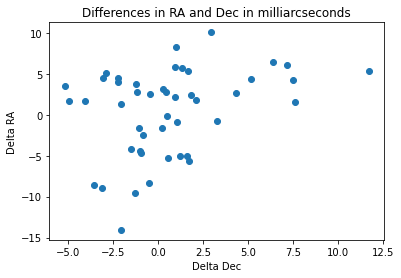

starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits


Image mean, median and std 11.394609 10.827406 55.007805
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 608.5461714111817 2.5131153270429225  0.0008811535076687153   -0.014594743852346248
 685.5165542363047  5.522005289569982      359.9985263490218   -0.014309429398466314
 886.3377102041173  32.12032234845156     359.99243210897583   -0.012997421405947096
  953.858650908105 37.038714754591744     359.99037445698593   -0.012674313169426505
 444.4760693354769 61.921174725845646   0.006066872395400456   -0.013223584608591675
 708.5375051993097  73.05653065791925      359.9979904139565   -0.012224485327696166
 373.6920713251912  82.73362445593573   0.008291490212003361   -0.012772364504572807
 429.1710480615856   96.9361473590585  0.0066252915340002895   -0.012205382067991825
486.33656507950644  111.0929968883717   0.004907122116154008   -0.011634266764592633
 812.816

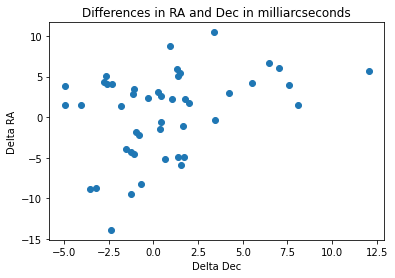

starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.459499 10.829639 55.680965
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
  632.757520509536  43.52799873198921  0.0008804967979520648  -0.014626457969967293
 709.8257801184594 47.507856164720145     359.99852516247785  -0.014311550857858348
 910.5959218383333  74.15073580836673     359.99243330115337  -0.012997209251142885
 978.1734916601412  79.09634950402457     359.99037406382115  -0.012674008968996101
 468.7130887677887 103.70932107395348   0.006068286014852335   -0.01322360404683915
  732.790984782116 114.80235210425441     359.99799208670777  -0.012224549793193257
  397.984710427444 124.51324600589399   0.008291256163280063  -0.012770390494991906
453.48648150451567  138.5482319055374   0.006624203827780067  -0.012205946184055615
 510.5826324979371 152.64448533976542   0.0

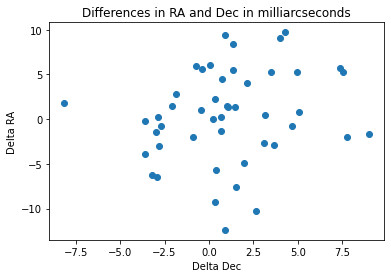

starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits
Image mean, median and std 11.461396 10.8295555 55.684906
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 632.7561014527342  43.52872182023289  0.0008805421841502914   -0.014626439834395417
 709.8260670657803   47.5058809583951     359.99852514867274   -0.014311609453108201
 910.5951520227544  74.15262735916836     359.99243332955854   -0.012997154434847552
 978.1739871993807   79.0963228230719     359.99037404856495   -0.012674008483594294
468.71224848996206 103.70989382247947   0.006068313256945353   -0.013223588820502662
 732.7915923131342 114.80647731539594     359.99799207867466   -0.012224423456660083
397.98413357499743 124.51335799099897   0.008291274143771397   -0.012770388542114123
  453.486222463101  138.5458169269537   0.006624205620663413   -0.012206020133662565
510.58256909558963  152.64532038

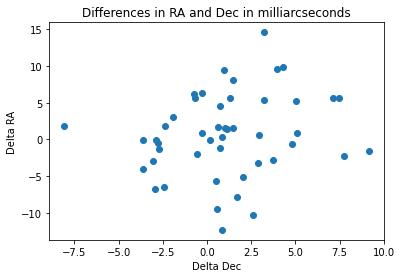

starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.166319 10.819193 52.431835
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 646.9460364189496 123.58824806720995  0.0008803409666353219    -0.01462544759401453
 724.0252320146072  127.5820452764259      359.9985251448545      -0.014310524077353
 924.8606761687124 154.24326052907645      359.9924329361845   -0.012996383566727537
   992.45691902968 159.27374467532363     359.99037339685844   -0.012673064323221303
482.87053476521277 183.28959656865936   0.006068231603246421   -0.013222390879844007
 747.0589422960411 194.39222695244513      359.9979919488258   -0.012223096373398978
412.11218706689084 203.90829274053294   0.008291045403339596   -0.012771385160995604
467.56583952342805 217.90372011464456    0.00662635936109802    -0.01220484372594049
 524.7770858845939 231.8931155015

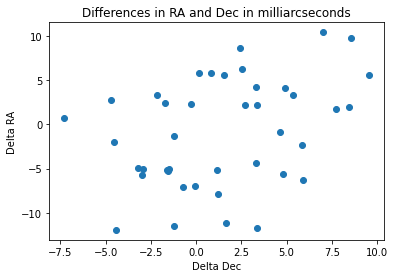

starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits
Image mean, median and std 11.167205 10.820021 52.420555
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
 646.9454800415763 123.59122321380107  0.0008803656879164385  -0.014625358834867506
 724.0256726768248 127.58013796160934      359.9985251264132   -0.01431058074881553
 924.8597080043684  154.2432706124099     359.99243296590157  -0.012996385708730001
 992.4534255006282  159.2718625921307      359.9903734990552  -0.012673130090554478
 482.8696673425391  183.2899835191299   0.006068259202637669  -0.013222381265036554
 747.0578849106864 194.39226082259032      359.9979919813537  -0.012223097981552028
 412.1139269048188 203.90945048821695    0.00829099500464183  -0.012771345469780142
467.56675428766414  217.9036290726527  0.0066263310760417415   -0.01220484420928609
 524.7779965210373 231.88761492892587   0.0

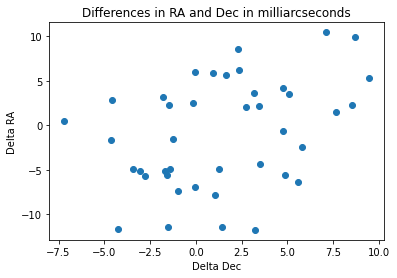

starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.14942 10.819677 52.3238
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 695.2882988999536 103.10651467532003  0.0008800008772832899   -0.014624813910079982
 772.3744183009295  107.0815682195305      359.9985245931245   -0.014309869787115948
  973.228381685913 133.63302595063803     359.99243224223216   -0.012997673379714877
 531.2457880501139 162.90678044840305   0.006067753827247839   -0.013222863142923662
 795.4098654036351 173.99541287004112      359.9979911433319   -0.012223925183360086
  460.547711377863  183.5249036196875   0.008289441834595316   -0.012772358696295038
 515.9706963233565 197.55498823067623   0.006625409028767752   -0.012205661433268716
 573.1045796641623 211.60813499707166   0.004909149394200925    -0.01163371221201762
 899.8933788590772 236.1964594074282

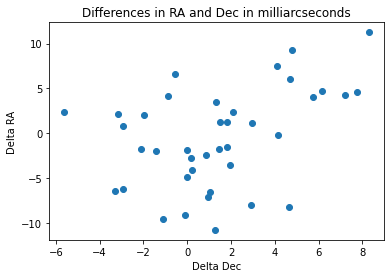

starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits
Image mean, median and std 11.148314 10.819933 52.31703
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
   695.28794170584 103.10641319490699  0.0008800115795231863   -0.01462481787900968
 772.3731936505352 107.08007937646431      359.9985246268782  -0.014309917872403828
 973.2281832908834  133.6348268676595       359.992432252969  -0.012997619538201288
 531.2461240972619 162.90616024026545   0.006067741924447004  -0.013222881168460607
 795.4082883628598  173.9964145346605     359.99799119432987   -0.01222389869223297
 460.5482539991836 183.52565213354322   0.008289427105149128  -0.012772334529918135
  515.971022928771 197.55386309448286   0.006625396116303293  -0.012205694933804823
 573.1055169320389  211.6075876893692  0.0049091192277255415  -0.011633726576394846
 899.8952017510751 236.19527724644132     35

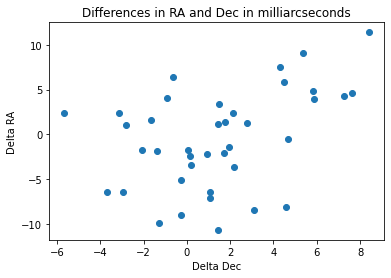

RA difference mean, median and std (units in mas) 1.1037660880047775 0.9281835036028911 3.549202125823858
Dec difference mean, median and std (units in mas) -0.06135758681286737 1.0161649008182116 5.550928948928192


In [10]:
# find stars and get RA, Dec from *_cal.fits files

# Run DAOStarFinder to find sources in image
allRAdiff_cal = []
allDecdiff_cal = []

for calimage in imagelist:
    image = ImageModel(calimage)
    
    # pull out data portion of input file
    data = image.data
    
    # print stats on input image
    print(calimage)
    mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
    print('Image mean, median and std',mean, median, std)

    ap_radius = 5.  # radius for aperture for centroiding and photometry

    daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
    sources = daofind(data)     

    # Create apertures for x,y positions
    positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
    #print(positions)

    #positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=ap_radius)
    
    # using wcs info from images, put coordinates into RA, Dec
    ra, dec = image.meta.wcs(sources['xcentroid'], sources['ycentroid'])

    # add RA, Dec to sources table

    ra_col = Column(name='RA', data=ra)
    dec_col = Column(name='Dec', data=dec)
    sources.add_column(ra_col)
    sources.add_column(dec_col)

    # print RA, Dec for each x, y position found
    #print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

    sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
    sources_sub.pprint_all()
    print()
    
    # read in text file with RA and Dec input coordinates
    RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

    # put RA and Dec into floats
    RA_sim = RA_in.astype(float)
    Dec_sim = Dec_in.astype(float)
    
    # Put ra, dec coords into a table
    cat1_sim = Table([RA_sim, Dec_sim], names=('ra', 'dec'))
    cat2_calc = Table([ra, dec], names=('ra', 'dec'))
    
    # Get coordinates with SkyCoord for each catalog
    
    coord_cat1_sim = SkyCoord(ra=cat1_sim['ra'], dec=cat1_sim['dec'], unit="deg")
    coord_cat2_calc = SkyCoord(ra=cat2_calc['ra'], dec=cat2_calc['dec'], unit="deg")
    ind_cat2_cat1, dist_2d, _ = match_coordinates_sky(coord_cat1_sim, coord_cat2_calc)
    
    # Find where the catalogs match
    
    cat1_matched = cat1_sim[dist_2d.arcsec<0.05]
    cat2_matched = cat2_calc[ind_cat2_cat1[dist_2d.arcsec<0.05]]
    
    #print(cat1_matched)
    
    # Get differences in RA, Dec
    ra_diff = cat2_matched['ra'] - cat1_matched['ra']
    dec_diff = cat2_matched['dec'] - cat1_matched['dec'] 
    
    #print(ra_diff)
    
    # put differences in milliarcseconds
    ra_diff = ra_diff * 3600000
    dec_diff = dec_diff * 3600000
    
    
    # Compare input RA, Dec to found RA, Dec
    print('RA_Diff (mas)  Dec_diff (mas) pass/fail')
    # Find if the differences are within the allowed 30 mas range
    for i in np.arange(0,len(ra_diff)):
        #if ra_diff[i] < 30 and dec_diff[i] < 30:
        allRAdiff_cal.append(ra_diff[i])
        allDecdiff_cal.append(dec_diff[i])
        if abs(ra_diff[i]) < 30 and abs(dec_diff[i]) < 30: 
            test = 'pass' 
        else: 
            test = 'fail'
        print('{:15.6f} {:15.6f} {}'.format(ra_diff[i], dec_diff[i], test))
 
    
    # Plot ra and dec differences
    plt.title ('Differences in RA and Dec in milliarcseconds')
    plt.ylabel('Delta RA')
    plt.xlabel('Delta Dec')
    plt.scatter(ra_diff,dec_diff)
    plt.show()
 
    # Plot should show no differences greater than 30 milliarcseconds  
    
meanRAdiff_cal, medianRAdiff_cal, stdRAdiff_cal = sigma_clipped_stats(allRAdiff_cal, sigma=5.0, maxiters=5)  # default sigma=3
meanDecdiff_cal, medianDecdiff_cal, stdDecdiff_cal = sigma_clipped_stats(allDecdiff_cal, sigma=5.0, maxiters=5)  # default sigma=3

print('RA difference mean, median and std (units in mas)',meanRAdiff_cal, medianRAdiff_cal, stdRAdiff_cal) 
print('Dec difference mean, median and std (units in mas)',meanDecdiff_cal, medianDecdiff_cal, stdDecdiff_cal)

### Run the images through calwebb_image3 with tweakreg on

Alter any parameters needed to get better results from tweakreg. Look at individual i2d images afterwards.

In [11]:
# use asn_from_list to create association table

#calfiles = glob.glob('starfield*_cal.fits')
asn = asn_from_list.asn_from_list(imagelist, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

print(asn)    

jwnoprogram-a3001_none_010_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	starfield_50star4ptdither_combined.fits with 8 members


In [12]:
# Run Calwebb_image3 on the association table with tweakreg on
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 3.318 #3.27  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 40 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom ='rshift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
#pipe3.tweakreg.save_catalogs = True
#pipe3.tweakreg.skip = True        # test to see if this affects the final output
pipe3.outlier_detection.skip = True # this is set in later step so mis-alignments aren't 'hidden'
pipe3.outlier_detection.skip = True
pipe3.source_catalog.save_results = True
pipe3.save_results = True
#pipe3.output_dir = datadir

# run Image3

#im = pipe3.run(rtdata.input)
image = pipe3.run('starfield_50star4ptdither_asnfile.json')
print('Image 3 pipeline finished.')

2021-08-28 02:19:14,578 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-08-28 02:19:14,580 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-08-28 02:19:14,581 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-08-28 02:19:14,583 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-08-28 02:19:14,584 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-08-28 02:19:14,585 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:19:14,587 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-08-28 02:19:14,686 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2021-08-28 02:19:14,691 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 40, 'brightest':

2021-08-28 02:19:14,782 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-08-28 02:19:14,790 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-08-28 02:19:14,791 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-08-28 02:19:14,792 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:19:14,793 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-08-28 02:19:15,635 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-08-28 02:19:15,638 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 40, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-08-28 02:19:15,865 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:19:16,111 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:19:16,351 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 49 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:19:16,612 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:19:16,848 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:19:17,101 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:19:17,343 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 43 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:19:17,559 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:19:17,577 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:17,578 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2021-08-28 02:19:17,578 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-08-28 02:19:17,602 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:19:17,603 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:19:17,625 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:19:17,626 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:19:17,649 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:19:17,649 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:19:17,672 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:19:17,673 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:19:17,695 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:19:17,696 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:19:17,719 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:19:17,719 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:19:17,742 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:19:17,743 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:19:17,767 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:19:17,767 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:19:17,767 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:17,768 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:19:17,768 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-08-28 02:19:17.768212


2021-08-28 02:19:17,768 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.3


2021-08-28 02:19:17,769 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:19:17,917 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2021-08-28 02:19:17,921 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:19:18,021 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:19:18,022 - stpipe.Image3Pipeline.tweakreg - INFO - Found 48 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:19:18,023 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:19:18,025 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2021-08-28 02:19:18,025 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -4.99872e-05  YSH: -1.34437e-05    ROT: 5.32927e-05    SCALE: 1


2021-08-28 02:19:18,026 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:18,026 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.000287318   FIT MAE: 0.000256544


2021-08-28 02:19:18,026 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2021-08-28 02:19:18,053 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/wcs.py:1990: DeprecationWarning: Indexing a WCS.pipeline step is deprecated. Use the `frame` and `transform` attributes instead.
  warnings.warn("Indexing a WCS.pipeline step is deprecated. "



2021-08-28 02:19:18,065 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-08-28 02:19:18,166 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:19:18,168 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2021-08-28 02:19:18,168 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:19:18,170 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2021-08-28 02:19:18,171 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000321171  YSH: -4.24579e-05    ROT: -0.000894824    SCALE: 1


2021-08-28 02:19:18,171 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:18,172 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00527931   FIT MAE: 0.00461642


2021-08-28 02:19:18,172 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-08-28 02:19:18,208 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:19:18,449 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:19:18,450 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:19:18,451 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:19:18,453 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal:


2021-08-28 02:19:18,454 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000338653  YSH: -0.000284604    ROT: -0.000801054    SCALE: 1


2021-08-28 02:19:18,454 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:18,454 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00545887   FIT MAE: 0.00479425


2021-08-28 02:19:18,455 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-08-28 02:19:18,491 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-08-28 02:19:18,588 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:19:18,589 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2021-08-28 02:19:18,590 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:19:18,592 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2021-08-28 02:19:18,593 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000303586  YSH: 0.00105847    ROT: -0.000552349    SCALE: 1


2021-08-28 02:19:18,593 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:18,593 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00771548   FIT MAE: 0.00684298


2021-08-28 02:19:18,594 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-08-28 02:19:18,631 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:19:18,729 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:19:18,730 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:19:18,731 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:19:18,733 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2021-08-28 02:19:18,733 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000286148  YSH: 0.00108692    ROT: -0.000523678    SCALE: 1


2021-08-28 02:19:18,734 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:18,734 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00770516   FIT MAE: 0.00682456


2021-08-28 02:19:18,734 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-08-28 02:19:18,771 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-08-28 02:19:18,872 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:19:18,874 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2021-08-28 02:19:18,874 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:19:18,877 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2021-08-28 02:19:18,877 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000237614  YSH: 0.00262767    ROT: 0.000387146    SCALE: 1


2021-08-28 02:19:18,878 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:18,878 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0110158   FIT MAE: 0.0068922


2021-08-28 02:19:18,879 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-08-28 02:19:18,916 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:19:19,022 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:19:19,024 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:19:19,024 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:19:19,027 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2021-08-28 02:19:19,028 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000265638  YSH: 0.00262238    ROT: 0.000458858    SCALE: 1


2021-08-28 02:19:19,028 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:19:19,028 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0110242   FIT MAE: 0.00691673


2021-08-28 02:19:19,029 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-08-28 02:19:19,066 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:19:19,067 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-08-28 02:19:19.066459


2021-08-28 02:19:19,067 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.298247


2021-08-28 02:19:19,067 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:19:19,306 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-08-28 02:19:19,474 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-08-28 02:19:19,476 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-08-28 02:19:19,532 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:19,533 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-08-28 02:19:19.532379


2021-08-28 02:19:19,533 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:19,534 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-08-28 02:19:19,534 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-08-28 02:19:19,534 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-08-28 02:19:19,535 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:19,535 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-08-28 02:19:26,306 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0109372


2021-08-28 02:19:26,307 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.022236


2021-08-28 02:19:26,307 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0132933


2021-08-28 02:19:26,308 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00937814


2021-08-28 02:19:26,308 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2021-08-28 02:19:26,309 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00884242


2021-08-28 02:19:26,309 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00383076


2021-08-28 02:19:26,309 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0136089


2021-08-28 02:19:26,310 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:26,310 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-08-28 02:19:26,462 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:26,462 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.812714931864468 [not converted]


2021-08-28 02:19:26,463 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:26,463 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-08-28 02:19:26,463 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8237 (old=0.0109372, delta=10.8127)


2021-08-28 02:19:26,464 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.835 (old=0.022236, delta=10.8127)


2021-08-28 02:19:26,464 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.826 (old=0.0132933, delta=10.8127)


2021-08-28 02:19:26,465 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8221 (old=0.00937814, delta=10.8127)


2021-08-28 02:19:26,465 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8127 (old=0, delta=10.8127)


2021-08-28 02:19:26,465 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8216 (old=0.00884242, delta=10.8127)


2021-08-28 02:19:26,466 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8165 (old=0.00383076, delta=10.8127)


2021-08-28 02:19:26,466 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8263 (old=0.0136089, delta=10.8127)


2021-08-28 02:19:26,466 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:26,467 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-08-28 02:19:26.466750


2021-08-28 02:19:26,467 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:06.934371


2021-08-28 02:19:26,467 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:19:26,480 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-08-28 02:19:26,606 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-08-28 02:19:26,608 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-08-28 02:19:26,608 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2021-08-28 02:19:26,613 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-08-28 02:19:26,722 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-08-28 02:19:26,723 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:19:26,737 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:19:26,892 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2021-08-28 02:19:27,439 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2021-08-28 02:19:28,008 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:29,151 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:30,314 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:31,448 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:32,584 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:33,712 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:34,845 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:35,964 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:36,379 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:19:36,927 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:38,050 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:39,187 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:40,355 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:41,518 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:42,644 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:43,775 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:44,908 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:45,399 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:19:45,936 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:47,066 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:48,203 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:49,326 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:50,437 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:51,556 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:52,679 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:53,831 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:54,326 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:19:54,863 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:55,973 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:57,084 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:58,212 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:19:59,370 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:00,750 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:02,133 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:03,476 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:03,989 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:20:03,991 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021512893 -0.020377290 0.024586045 0.014642008 359.990548023 0.017629048 359.987474870 -0.017390249


2021-08-28 02:20:04,386 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2021-08-28 02:20:04,387 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-08-28 02:20:04,539 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_50star4ptdither_combined_i2d.fits>,).


2021-08-28 02:20:04,541 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-08-28 02:20:04,560 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-08-28 02:20:04,567 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-08-28 02:20:04,568 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-08-28 02:20:04,568 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-08-28 02:20:04,569 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-08-28 02:20:04,569 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-08-28 02:20:04,606 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-08-28 02:20:05,011 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 665 sources


2021-08-28 02:20:05,681 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2021-08-28 02:20:05,771 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:20:05,773 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:20:05,774 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-08-28 02:20:05,775 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


### Get position differences as found earlier for the individual i2d files

['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits', 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_i2d.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_i2d.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_i2d.fits']

starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits
Image mean, median and std 10.091457 10.796132 50.790142
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 602.8518714876282 3.6008978843515886  0.0008819522509096922   -0.014601674495986792
 679.9457317632593  6.236558003637516     359.99852497047624   -0.014313390551491466
  880.853223043022 31.521037340728547

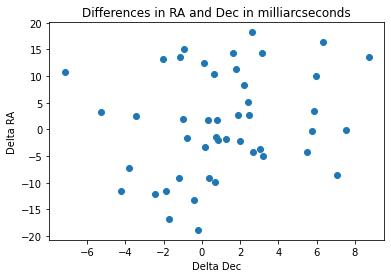

starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_i2d.fits
Image mean, median and std 10.090668 10.796824 50.761265
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
 602.8537062878535   3.60020944407146  0.0008818941343590366  -0.014601690669428518
 679.9476892374303  6.236223902693174     359.99852490955146   -0.01431339552904258
 880.8556583364457 31.510121658249375      359.9924321025269  -0.012997725338385075
 948.4214442598872 36.256837806225654      359.9903729790695  -0.012670346362708664
438.93064173009645 62.927015426928506   0.006068226260194663  -0.013223562518609849
  703.129063444857  72.42446356978068     359.99799216972923  -0.012221359116151336
 368.2984762727767  83.95853400142276   0.008290749945676966  -0.012768706502291465
 423.7599843627015  97.54024916444838   0.006626577899079173  -0.012202976360884965
 481.0003231497586 111.01762997835094  0.00

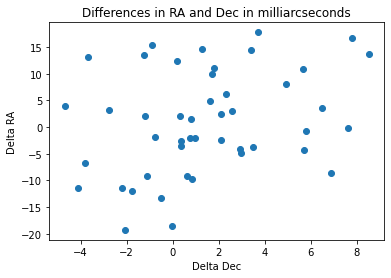

starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits
Image mean, median and std 10.1105995 10.798032 50.863968
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ --------------------- -----------------------
 627.2982384405495  43.78548079592043 0.0008795936228094739   -0.014625425802744422
 704.4131464120393  47.21203299058368     359.9985240947273   -0.014312832594876732
 905.2918224754756  72.51690488624786     359.9924322693176   -0.012996291386001677
 972.8043720450302  77.10496974855552    359.99037435141423   -0.012673920686433434
 463.4171721524288 103.88844476432784   0.00606672656533526   -0.013223383837893631
  727.542733158319 113.36243195627799     359.9979928411359    -0.01222209590327961
392.70795229902416 124.90635161687395  0.008291576498491321   -0.012769152579607175
 448.2236144031241 138.44672171239546  0.006625632554263813   -0.012204544540034997
 505.4688310529834 152.12524171737894  0.0

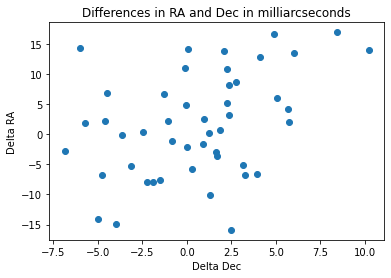

starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits
Image mean, median and std 10.112085 10.798991 50.85573
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 627.2942925118597   43.7906461694201  0.0008797285244249543   -0.014625278025767564
 704.4108923972478  47.21386754193602     359.99852416878326   -0.014312782404175817
 905.2918743719139  72.51075470558935      359.9924322511759   -0.012996479840935231
 972.7803797552901  77.11030666686527      359.9903751014968   -0.012673821594401564
463.40697685117505 103.89546314278559   0.006067058089735734   -0.013223196055963561
 727.5382030860469 113.36396426016982      359.9979929841735   -0.012222061105928547
 392.7077119108454 124.90702249333656   0.008291585675311332   -0.012769132654134726
 448.2226128507119  138.4447174769215   0.006625657873300073   -0.012204608694868927
505.46884341490323 152.12545078680

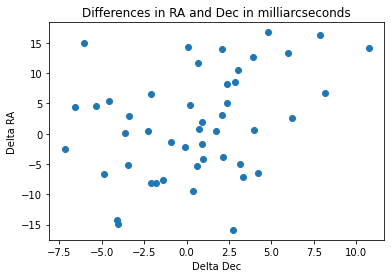

starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits
Image mean, median and std 9.822638 10.788436 47.82297
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
 641.7227003865544 122.40951264293068  0.0008799934005888493  -0.014626386155063726
  718.815885928043 125.93989351615451     359.99852544000805  -0.014310667500264931
 919.7136275426241 151.15984186898842      359.9924328013891  -0.012996679127948331
 987.2483489817446 155.70860610390267      359.9903740978196  -0.012675453905560324
 477.8170348339017 182.53757476766552  0.0060679482643693815  -0.013223640735401465
 742.0029646661105  192.0070683044656     359.99799219948073  -0.012222328120787019
 407.1485409215753 203.45298939738487   0.008291273550370442  -0.012772442789168425
462.64987316270816  217.0847831943875   0.006626015039169051  -0.012205069803826277
 519.8870125625718  230.6982660454576   0.004

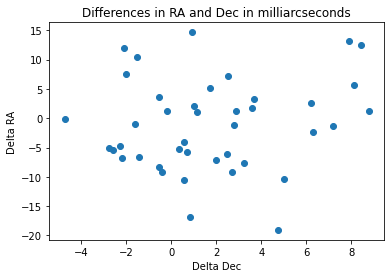

starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_i2d.fits
Image mean, median and std 9.822578 10.788697 47.821087
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 641.7228166768773  122.4121359295773   0.000879996893898583   -0.014626305399335291
  718.829727317658 125.92633067783606     359.99852497906545   -0.014311046155557164
  919.706119823212  151.1629088777233      359.9924330398659    -0.01299660528195927
  987.244287435933 155.70744366752422      359.9903742192383   -0.012675500481279833
477.81550142031745 182.53713382614595   0.006067994099737253   -0.013223658383303702
 742.0039078022609 192.00855592599353      359.9979921745628   -0.012222279965035457
 407.1542751346656   203.439962485529   0.008291062655604997   -0.012772826827015596
462.64891921662485 217.08461954217884   0.006626043851424161   -0.012205077389291176
 519.8986729948123  230.6761879513

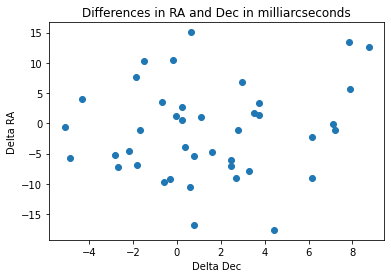

starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits
Image mean, median and std 9.816838 10.789823 48.315887
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 689.9883695183636 101.85249747918233   0.000880494627604281   -0.014628032252966251
 767.1146544753882 105.40654002150126      359.9985249899391    -0.01431149893058481
 968.0037635883841 130.62789753238783      359.9924326199003   -0.012997490549186596
  526.097191640674 162.16814833601413   0.006068510011732581   -0.013219495500390447
 790.3062847110347  171.4650547953246     359.99799158654145   -0.012223412872813316
455.47082844885335  182.9287883872101   0.008290126859551163   -0.012772930338668083
 510.9543271567537  196.5738119695463  0.0066254508153852235   -0.012205199645730662
 568.1112222112675 210.13790423889915   0.004909242477189329    -0.01163544753464979
 894.8526337368794  232.5226338425

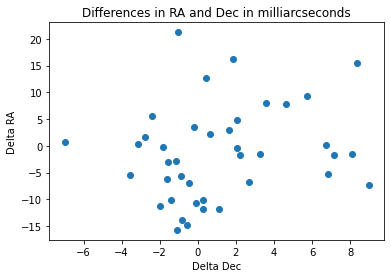

starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_i2d.fits
Image mean, median and std 9.816793 10.789996 48.29586
    xcentroid          ycentroid                RA                   Dec          
------------------ ------------------ --------------------- ----------------------
 689.9885901264787 101.85033664912017 0.0008804820478196955  -0.014628097920923358
 767.1119152629705 105.40818972560808    359.99852507837613   -0.01431145571390041
 968.0034768071495 130.62980461337932     359.9924326338264  -0.012997432840511402
 526.0994467554968  162.1562969059541  0.006068408966369632  -0.013219852854547274
 790.3061510107007  171.4699540522718    359.99799160382537  -0.012223262997461432
455.46995521840296 182.93305913430726  0.008290165129760562  -0.012772801726577855
 510.9546501400181 196.57274124482367   0.00662543802979007  -0.012205231610229541
  568.112555467316  210.1375163258603  0.004909200549160662  -0.011635455842126224
 894.8465072186234 232.50221152757368     359.994950125

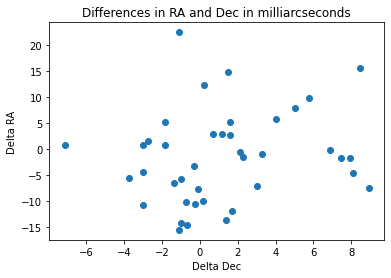

RA difference mean, median and std (units in mas) 1.1304946902568231 0.7871462078333502 3.6212790667708883
Dec difference mean, median and std (units in mas) 0.09565537802571689 -0.22551204218387855 8.784219193377282


In [13]:
# find stars and get RA, Dec from *_i2d.fits files

#datadir = '/ifs/jwst/wit/miri/pipelinetests/cracraft/build7_8/'
#filelist = 'starfield_50star4ptdither_i2dfiles.txt'
filelist = glob.glob('*exp*i2d.fits')
print(filelist)
print()

# Run DAOStarFinder to find sources in image
allRAdiff_i2d = []
allDecdiff_i2d = []

for i2dimage in filelist:
    image = ImageModel(i2dimage)
    
    # pull out data portion of input file
    data = image.data
    
    # print stats on input image
    print(i2dimage)
    mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
    print('Image mean, median and std',mean, median, std)

    ap_radius = 5.  # radius for aperture for centroiding and photometry

    daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
    sources = daofind(data)    

    #sources.pprint_all()
    #print(sources['xcentroid','ycentroid','peak'])   

    # Create apertures for x,y positions
    positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
    #print(positions)

    #positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=ap_radius)
    
    # using wcs info from images, put coordinates into RA, Dec
    ra, dec = image.meta.wcs(sources['xcentroid'], sources['ycentroid'])

    # add RA, Dec to sources table

    ra_col = Column(name='RA', data=ra)
    dec_col = Column(name='Dec', data=dec)
    sources.add_column(ra_col)
    sources.add_column(dec_col)

    # print RA, Dec for each x, y position found
    #print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

    sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
    sources_sub.pprint_all()
    print()
    
    # read in text file with RA and Dec input coordinates
    RA_in, Dec_in = np.loadtxt( coords, dtype=str, unpack=True)

    # put RA and Dec into floats
    RA_sim = RA_in.astype(float)
    Dec_sim = Dec_in.astype(float)
    
    # Put ra, dec coords into a table
    cat1_sim = Table([RA_sim, Dec_sim], names=('ra', 'dec'))
    cat2_calc = Table([ra, dec], names=('ra', 'dec'))
    
    # Get coordinates with SkyCoord for each catalog
    
    coord_cat1_sim = SkyCoord(ra=cat1_sim['ra'], dec=cat1_sim['dec'], unit="deg")
    coord_cat2_calc = SkyCoord(ra=cat2_calc['ra'], dec=cat2_calc['dec'], unit="deg")
    ind_cat2_cat1, dist_2d, _ = match_coordinates_sky(coord_cat1_sim, coord_cat2_calc)
    
    # Find where the catalogs match
    
    cat1_matched = cat1_sim[dist_2d.arcsec<0.05]
    cat2_matched = cat2_calc[ind_cat2_cat1[dist_2d.arcsec<0.05]]
    
    #print(cat1_matched)
    
    # Get differences in RA, Dec
    ra_diff = cat2_matched['ra'] - cat1_matched['ra']
    dec_diff = cat2_matched['dec'] - cat1_matched['dec'] 
    
    #print(ra_diff)
    
    # put differences in milliarcseconds
    ra_diff = ra_diff * 3600000
    dec_diff = dec_diff * 3600000
    
    
    # Compare input RA, Dec to found RA, Dec
    print('RA_Diff (mas)  Dec_diff (mas) pass/fail')
    # Find if the differences are within the allowed 30 mas range
    for i in np.arange(0,len(ra_diff)):
        #if ra_diff[i] < 30 and dec_diff[i] < 30:
        allRAdiff_i2d.append(ra_diff[i])
        allDecdiff_i2d.append(dec_diff[i])
        if abs(ra_diff[i]) < 30 and abs(dec_diff[i]) < 30: 
            test = 'pass' 
        else: 
            test = 'fail'
        print('{:15.6f} {:15.6f} {}'.format(ra_diff[i], dec_diff[i], test))
 
    
    # Plot ra and dec differences
    plt.title ('Differences in RA and Dec in milliarcseconds')
    plt.ylabel('Delta RA')
    plt.xlabel('Delta Dec')
    plt.scatter(ra_diff,dec_diff)
    plt.show()

    # Plot should show no differences greater than 30 milliarcseconds  

    
meanRAdiff_i2d, medianRAdiff_i2d, stdRAdiff_i2d = sigma_clipped_stats(allRAdiff_i2d, sigma=5.0, maxiters=5)  # default sigma=3
meanDecdiff_i2d, medianDecdiff_i2d, stdDecdiff_i2d = sigma_clipped_stats(allDecdiff_i2d, sigma=5.0, maxiters=5)  # default sigma=3

print('RA difference mean, median and std (units in mas)',meanRAdiff_i2d, medianRAdiff_i2d, stdRAdiff_i2d) 
print('Dec difference mean, median and std (units in mas)',meanDecdiff_i2d, medianDecdiff_i2d, stdDecdiff_i2d)

### Look at positions of RA, Dec and get stats on differences for the combined image run with tweakreg on

In [14]:
im = ImageModel('starfield_50star4ptdither_combined_i2d.fits')
pixarea = im.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea)

# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 2.84403609523084e-13
Image mean, median and std 1.9935058 0.0 46.597652


    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
  684.034980321269 127.53398844539224  0.0008802356343729342  -0.014625718676206137
 761.1417182748665 131.00120942423692     359.99852509670836  -0.014311900345246747
 962.0440451763197 156.25972282333117      359.9924324212947  -0.012996717054211984
1029.5284666496666 160.74893696179484      359.9903750999277  -0.012677453290043333
  520.136842038091 187.64742742099904  0.0060679202903298575  -0.013223401436989319
 784.3356555548421 197.08543265702477     359.99799169173775   -0.01222301974462638
449.51876246147486  208.5702340961972   0.008289719506872666   -0.01277184115407602
504.97946131176735 222.20944283867547   0.006625726976872019  -0.012204350141108225
 562.1911586543955 235.79122461842772   0.004907885739730672  -0.011633908121500811
 888.8695246164107  258.1098281382495     359.99495039096337  -0.01007041009

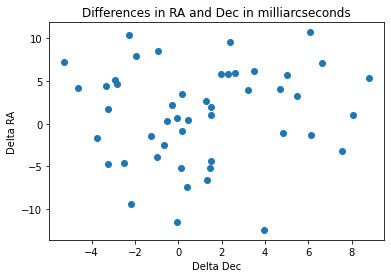

RA difference mean, median and std (units in mas) 1.0447150115866328 0.4193740656094932 3.454680844669165
Dec difference mean, median and std (units in mas) 1.1378019376743747 1.9004884697408633 5.561993337556168


In [15]:
# Run DAOStarFinder to find sources in image

ap_radius = 5.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)

# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
sources_sub.pprint_all()
print()

# Compare input RA, Dec to found RA, Dec
#print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas) pass/fail')

deltara_twon = []
deltadec_twon = []

# Put ra, dec coords into a table
cat1_sim = Table([RA_sim, Dec_sim], names=('ra', 'dec'))
cat2_calc = Table([ra, dec], names=('ra', 'dec'))
    
# Get coordinates with SkyCoord for each catalog
    
coord_cat1_sim = SkyCoord(ra=cat1_sim['ra'], dec=cat1_sim['dec'], unit="deg")
coord_cat2_calc = SkyCoord(ra=cat2_calc['ra'], dec=cat2_calc['dec'], unit="deg")    
ind_cat2_cat1, dist_2d, _ = match_coordinates_sky(coord_cat1_sim, coord_cat2_calc)
    
# Find where the catalogs match
    
cat1_matched = cat1_sim[dist_2d.arcsec<0.05]
cat2_matched = cat2_calc[ind_cat2_cat1[dist_2d.arcsec<0.05]]
    
#print(cat1_matched)
    
# Get differences in RA, Dec
ra_diff = cat2_matched['ra'] - cat1_matched['ra']
dec_diff = cat2_matched['dec'] - cat1_matched['dec'] 
    
#print(ra_diff)
    
# put differences in milliarcseconds
ra_diff = ra_diff * 3600000
dec_diff = dec_diff * 3600000
    
    
# Compare input RA, Dec to found RA, Dec
print('RA_Diff (mas)  Dec_diff (mas) pass/fail')
# Find if the differences are within the allowed 30 mas range
for i in np.arange(0,len(ra_diff)):
    #if ra_diff[i] < 30 and dec_diff[i] < 30:
    deltara_twon.append(ra_diff[i])
    deltadec_twon.append(dec_diff[i])
    if abs(ra_diff[i]) < 30 and abs(dec_diff[i]) < 30: 
        test = 'pass' 
    else: 
        test = 'fail'
    print('{:15.6f} {:15.6f} {}'.format(ra_diff[i], dec_diff[i], test))
 
    
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in milliarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltara_twon,deltadec_twon)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds  
     
meanRAdiff_twon, medianRAdiff_twon, stdRAdiff_twon = sigma_clipped_stats(deltara_twon, sigma=5.0, maxiters=5)  # default sigma=3
meanDecdiff_twon, medianDecdiff_twon, stdDecdiff_twon = sigma_clipped_stats(deltadec_twon, sigma=5.0, maxiters=5)  # default sigma=3

print('RA difference mean, median and std (units in mas)',meanRAdiff_twon, medianRAdiff_twon, stdRAdiff_twon) 
print('Dec difference mean, median and std (units in mas)',meanDecdiff_twon, medianDecdiff_twon, stdDecdiff_twon)

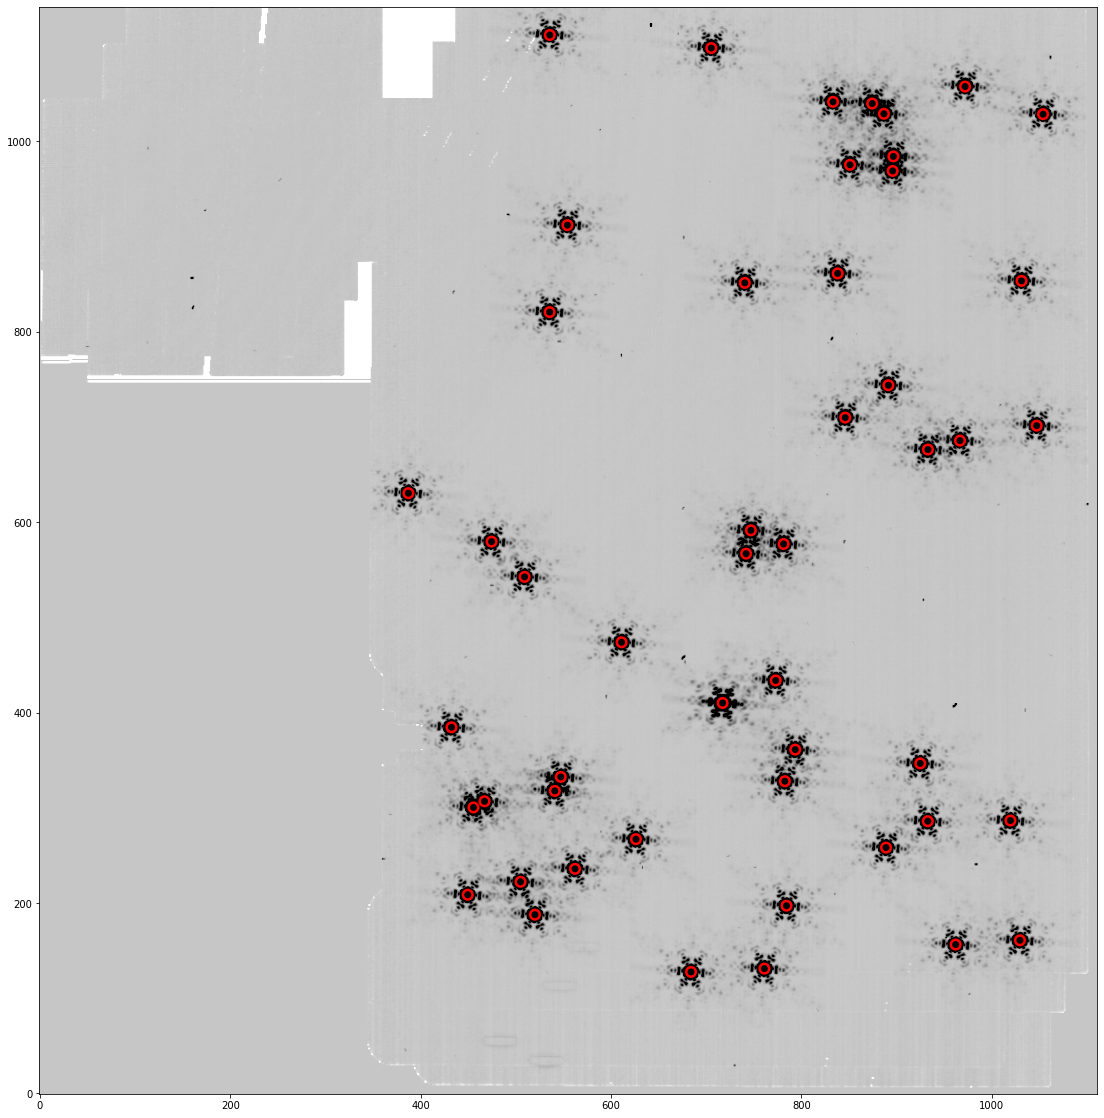

In [16]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='Greys', origin='lower', vmin=-5,vmax=10)#, norm=norm)
apertures.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

### Run calwebb_image3 with tweakreg turned off

Re-run the pipeline with tweakreg turned off to see if the differences found in the previous step are due to tweakreg alone, or differences in the distortion model that would show up in any run of the calwebb_image3 pipeline.

In [17]:
# Run Calwebb_image3 on the association table with tweakreg off
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 3.318 #3.27  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 10 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom ='rshift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
#pipe3.tweakreg.kernel_fwhm = fwhm
#pipe3.tweakreg.snr_threshold = snr
#pipe3.tweakreg.minobj = minobj
#pipe3.tweakreg.sigma = sigma
#pipe3.tweakreg.fitgeometry = fit_geom
#pipe3.tweakreg.use2dhist = use2dhist
pipe3.tweakreg.skip = True        # test to see if this affects the final output
pipe3.outlier_detection.skip = True # this is set in later step so mis-alignments aren't 'hidden'
pipe3.source_catalog.save_results = True
pipe3.save_results = True
#pipe3.output_dir = datadir

# run Image3

#im = pipe3.run(rtdata.input)
image = pipe3.run('starfield_50star4ptdither_asnfile.json')
print('Image 3 pipeline finished.')

2021-08-28 02:20:09,121 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-08-28 02:20:09,123 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-08-28 02:20:09,124 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-08-28 02:20:09,126 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-08-28 02:20:09,127 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-08-28 02:20:09,128 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:20:09,129 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-08-28 02:20:09,234 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2021-08-28 02:20:09,240 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 

2021-08-28 02:20:09,332 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-08-28 02:20:09,334 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-08-28 02:20:09,336 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-08-28 02:20:09,337 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:20:09,338 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-08-28 02:20:10,207 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-08-28 02:20:10,209 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 15, 'searchrad': 1.0, 'use2dhist': True, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'general', 'nclip': 3, 'sigma': 3.0, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-08-28 02:20:10,209 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2021-08-28 02:20:10,214 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-08-28 02:20:10,323 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-08-28 02:20:10,324 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-08-28 02:20:10,402 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:10,403 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-08-28 02:20:10.402506


2021-08-28 02:20:10,403 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:10,403 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-08-28 02:20:10,404 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-08-28 02:20:10,404 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-08-28 02:20:10,405 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:10,405 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-08-28 02:20:16,994 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0109372


2021-08-28 02:20:16,995 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.022236


2021-08-28 02:20:16,996 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0132933


2021-08-28 02:20:16,996 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00937814


2021-08-28 02:20:16,996 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2021-08-28 02:20:16,997 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00884242


2021-08-28 02:20:16,997 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00383076


2021-08-28 02:20:16,998 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0136089


2021-08-28 02:20:16,998 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:16,999 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-08-28 02:20:17,149 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:17,150 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.812714931864468 [not converted]


2021-08-28 02:20:17,150 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:17,151 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-08-28 02:20:17,151 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8237 (old=0.0109372, delta=10.8127)


2021-08-28 02:20:17,151 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.835 (old=0.022236, delta=10.8127)


2021-08-28 02:20:17,152 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.826 (old=0.0132933, delta=10.8127)


2021-08-28 02:20:17,152 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8221 (old=0.00937814, delta=10.8127)


2021-08-28 02:20:17,152 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8127 (old=0, delta=10.8127)


2021-08-28 02:20:17,152 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8216 (old=0.00884242, delta=10.8127)


2021-08-28 02:20:17,153 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8165 (old=0.00383076, delta=10.8127)


2021-08-28 02:20:17,153 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8263 (old=0.0136089, delta=10.8127)


2021-08-28 02:20:17,153 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:17,153 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-08-28 02:20:17.153653


2021-08-28 02:20:17,154 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:06.751147


2021-08-28 02:20:17,154 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:20:17,168 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-08-28 02:20:17,293 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-08-28 02:20:17,294 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-08-28 02:20:17,295 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2021-08-28 02:20:17,300 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-08-28 02:20:17,409 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-08-28 02:20:17,411 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:20:17,424 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:20:17,568 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2021-08-28 02:20:18,123 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2021-08-28 02:20:18,671 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:19,635 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:20,599 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:21,557 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:22,522 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:23,485 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:24,456 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:25,411 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:25,818 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:20:26,365 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:27,326 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:28,297 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:29,262 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:30,238 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:31,210 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:32,171 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:33,129 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:33,625 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:20:34,168 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:35,127 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:36,100 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:37,058 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:38,025 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:39,009 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:39,982 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:40,945 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:41,447 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:20:41,988 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:43,083 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:44,171 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:45,236 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:46,286 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:47,287 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:48,318 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:49,322 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:20:49,860 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:20:49,862 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021513048 -0.020377659 0.024586201 0.014641639 359.990548179 0.017628679 359.987475025 -0.017390618


2021-08-28 02:20:50,243 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2021-08-28 02:20:50,244 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-08-28 02:20:50,372 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_50star4ptdither_combined_i2d.fits>,).


2021-08-28 02:20:50,373 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-08-28 02:20:50,389 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-08-28 02:20:50,398 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-08-28 02:20:50,399 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-08-28 02:20:50,399 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-08-28 02:20:50,399 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-08-28 02:20:50,400 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-08-28 02:20:50,436 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-08-28 02:20:50,853 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 663 sources


2021-08-28 02:20:51,563 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2021-08-28 02:20:51,657 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:20:51,658 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:20:51,659 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-08-28 02:20:51,660 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


In [18]:
im = ImageModel('starfield_50star4ptdither_combined_i2d.fits')
pixarea = im.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea)

# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 2.84403609523084e-13


Image mean, median and std 1.993806 0.0 46.609962


    xcentroid          ycentroid                RA                   Dec          
------------------ ------------------ --------------------- ----------------------
 684.0400698585463  127.5400100515247 0.0008802511796999219  -0.014625889206972624
 761.1468556564452 131.00067729567522     359.9985250931503  -0.014312271716775992
 962.0489284066687 156.26385686491724    359.99243243808695  -0.012996946022075776
1029.5366909532854  160.7591742082718     359.9903750306902  -0.012677486112921606
 520.1418020552057 187.65026263826152  0.006067931232727763  -0.013223670026533024
 784.3408984326752 197.09169125633446    359.99799170321864  -0.012223182595357774
449.42382202266435  208.5751025120351  0.008292799356770023   -0.01277231623065702
504.98438782660713 222.21189600823215  0.006625737918511884  -0.012204630536236933
 562.1960390803579 235.79542972828344  0.004907902809198556   -0.01163413491764065
 888.8744071428839  258.1155188936408    359.99495041196633  -0.010070591332216551
 626

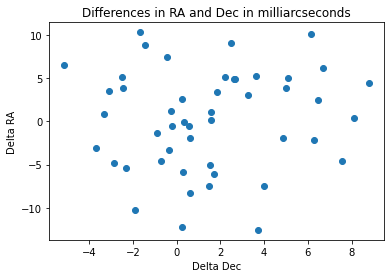

RA difference mean, median and std (units in mas) 1.4340044581710654 1.03965571612288 3.323691372967138
Dec difference mean, median and std (units in mas) 0.22396098505807513 0.6291390369173033 5.730980813206774


In [19]:
# Run DAOStarFinder to find sources in image

ap_radius = 5.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    

#sources.pprint_all()
#print(sources['xcentroid','ycentroid','peak'])   

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)


# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
sources_sub.pprint_all()
print()

# Compare input RA, Dec to found RA, Dec
#print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas) pass/fail')

deltara_twoff = []
deltadec_twoff = []

# Put ra, dec coords into a table
cat1_sim = Table([RA_sim, Dec_sim], names=('ra', 'dec'))
cat2_calc = Table([ra, dec], names=('ra', 'dec'))
    
# Get coordinates with SkyCoord for each catalog
    
coord_cat1_sim = SkyCoord(ra=cat1_sim['ra'], dec=cat1_sim['dec'], unit="deg")
coord_cat2_calc = SkyCoord(ra=cat2_calc['ra'], dec=cat2_calc['dec'], unit="deg")    
ind_cat2_cat1, dist_2d, _ = match_coordinates_sky(coord_cat1_sim, coord_cat2_calc)
    
# Find where the catalogs match
    
cat1_matched = cat1_sim[dist_2d.arcsec<0.05]
cat2_matched = cat2_calc[ind_cat2_cat1[dist_2d.arcsec<0.05]]
    
#print(cat1_matched)
    
# Get differences in RA, Dec
ra_diff = cat2_matched['ra'] - cat1_matched['ra']
dec_diff = cat2_matched['dec'] - cat1_matched['dec'] 
    
#print(ra_diff)
    
# put differences in milliarcseconds
ra_diff = ra_diff * 3600000
dec_diff = dec_diff * 3600000
    
    
# Compare input RA, Dec to found RA, Dec
print('RA_Diff (mas)  Dec_diff (mas) pass/fail')
# Find if the differences are within the allowed 30 mas range
for i in np.arange(0,len(ra_diff)):
    #if ra_diff[i] < 30 and dec_diff[i] < 30:
    deltara_twoff.append(ra_diff[i])
    deltadec_twoff.append(dec_diff[i])
    if abs(ra_diff[i]) < 30 and abs(dec_diff[i]) < 30: 
        test = 'pass' 
    else: 
        test = 'fail'
    print('{:15.6f} {:15.6f} {}'.format(ra_diff[i], dec_diff[i], test))
 
    
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in milliarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltara_twoff,deltadec_twoff)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds      
    
meanRAdiff_twoff, medianRAdiff_twoff, stdRAdiff_twoff = sigma_clipped_stats(deltara_twoff, sigma=5.0, maxiters=5)  # default sigma=3
meanDecdiff_twoff, medianDecdiff_twoff, stdDecdiff_twoff = sigma_clipped_stats(deltadec_twoff, sigma=5.0, maxiters=5)  # default sigma=3

print('RA difference mean, median and std (units in mas)',meanRAdiff_twoff, medianRAdiff_twoff, stdRAdiff_twoff) 
print('Dec difference mean, median and std (units in mas)',meanDecdiff_twoff, medianDecdiff_twoff, stdDecdiff_twoff)

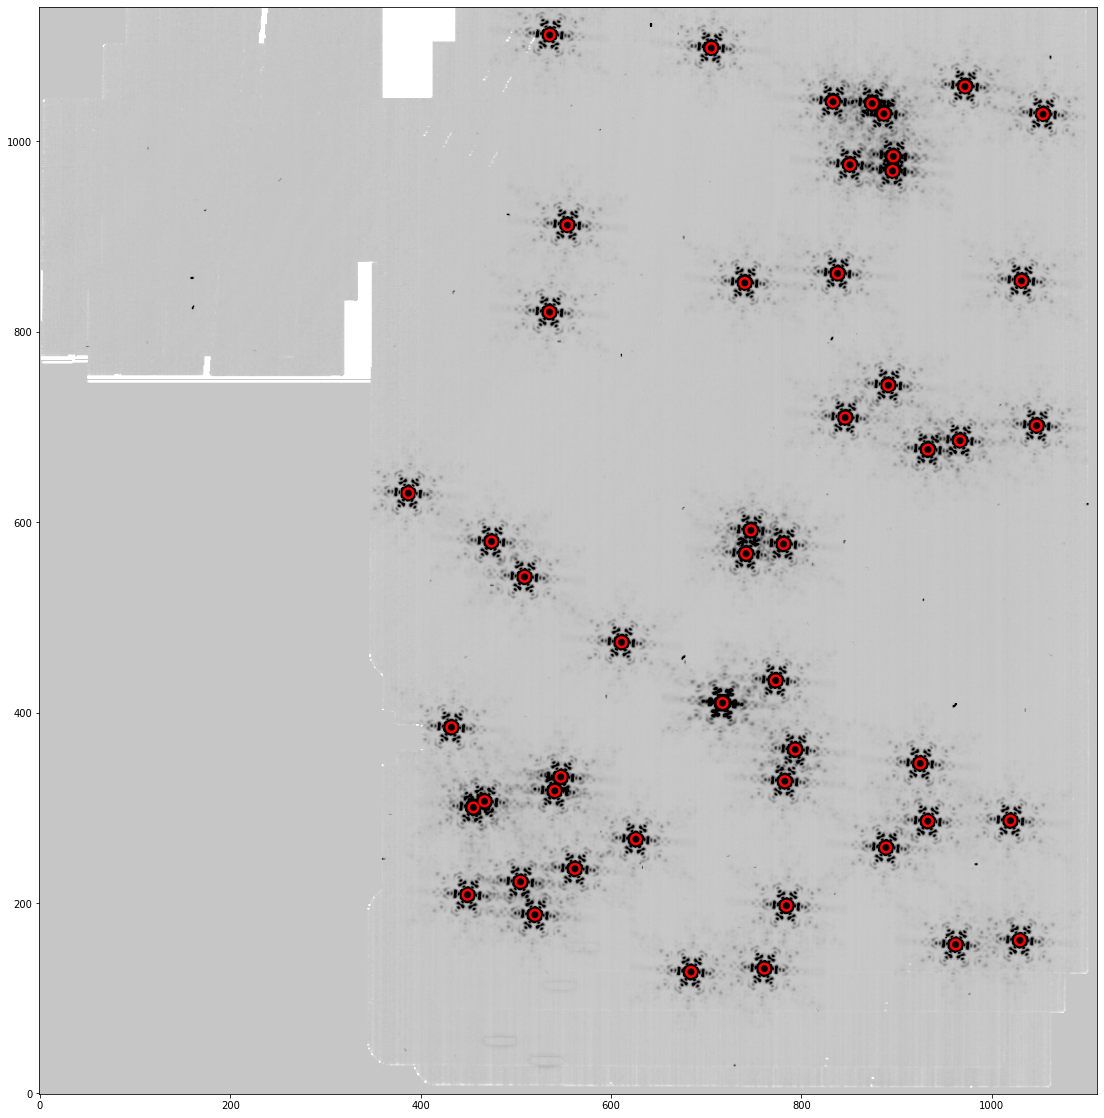

In [20]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='Greys', origin='lower', vmin=-5,vmax=10)#, norm=norm)
apertures.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

In [21]:
# Compare stats across tests:

print('All units are milliarcseconds for statistics')
print('Statistics on differences between RA and Dec in individual calibrated files')
print('RA difference mean, median and std',meanRAdiff_cal, medianRAdiff_cal, stdRAdiff_cal) 
print('Dec difference mean, median and std',meanDecdiff_cal, medianDecdiff_cal, stdDecdiff_cal)
print()
print('Statistics on differences between RA and Dec in individual i2d files when run with tweakreg on')
print('RA difference mean, median and std',meanRAdiff_i2d, medianRAdiff_i2d, stdRAdiff_i2d) 
print('Dec difference mean, median and std',meanDecdiff_i2d, medianDecdiff_i2d, stdDecdiff_i2d)
print()
print('Statistics on differences between RA and Dec in combined i2d file when run with tweakreg on')
print('RA difference mean, median and std',meanRAdiff_twon, medianRAdiff_twon, stdRAdiff_twon) 
print('Dec difference mean, median and std',meanDecdiff_twon, medianDecdiff_twon, stdDecdiff_twon)
print()
print('Statistics on differences between RA and Dec in combined i2d file when run with tweakreg off')
print('RA difference mean, median and std',meanRAdiff_twoff, medianRAdiff_twoff, stdRAdiff_twoff) 
print('Dec difference mean, median and std',meanDecdiff_twoff, medianDecdiff_twoff, stdDecdiff_twoff)

All units are milliarcseconds for statistics
Statistics on differences between RA and Dec in individual calibrated files
RA difference mean, median and std 1.1037660880047775 0.9281835036028911 3.549202125823858
Dec difference mean, median and std -0.06135758681286737 1.0161649008182116 5.550928948928192

Statistics on differences between RA and Dec in individual i2d files when run with tweakreg on
RA difference mean, median and std 1.1304946902568231 0.7871462078333502 3.6212790667708883
Dec difference mean, median and std 0.09565537802571689 -0.22551204218387855 8.784219193377282

Statistics on differences between RA and Dec in combined i2d file when run with tweakreg on
RA difference mean, median and std 1.0447150115866328 0.4193740656094932 3.454680844669165
Dec difference mean, median and std 1.1378019376743747 1.9004884697408633 5.561993337556168

Statistics on differences between RA and Dec in combined i2d file when run with tweakreg off
RA difference mean, median and std 1.4340

## Test # 2: See what happens with tweakreg when there are shifts between images not tracked in the wcs.

This test uses MIRISim data using only the simulated dithers, and one shifted image. Two exposures each of four different dithers. 

First look at the cal images out of calwebb_image2. 
* Apply 2 arcsecond shift to x and y positions of one image
* Use DAOStarFinder to get the x,y positions of the stars in each image
* Use wcs info from image to convert x,y positions to RA, Dec
* Compare the RA, Dec calculated values to the RA, Dec positions put into the simulated images
* Get statistics on the differences of the calculated and input positions in units of mas


In [22]:
# apply shifts to files in input list

# Read in a single rate.fits file, modify header values RA_REF and DEC_REF by adding in a shift of less than one 
# arcsecond, which is the default search radius for tweakreg
# 0.72 arcseconds ~ 0.0002 degrees

origfile = 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits'

model = ImageModel(origfile)

# modify header vaules

model.meta.wcsinfo.ra_ref = model.meta.wcsinfo.ra_ref + 0.0002
model.meta.wcsinfo.dec_ref = model.meta.wcsinfo.dec_ref + 0.0002

# Run file through calwebb_image2 to get cal.fits version and then retest steps in Test # 1.

# create an object for the pipeline    
pipe2 = Image2Pipeline()
pipe2.save_results = True
#pipe2.output_file = rampfile+'_cal.fits'
#pipe2.output_dir = datadir
pipe2.run(model)


2021-08-28 02:20:52,874 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2021-08-28 02:20:52,876 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2021-08-28 02:20:52,877 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2021-08-28 02:20:52,878 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2021-08-28 02:20:52,879 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2021-08-28 02:20:52,880 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:20:53,032 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:20:53,036 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip

2021-08-28 02:20:53,043 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2021-08-28 02:20:53,049 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2021-08-28 02:20:53,051 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2021-08-28 02:20:53,051 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2021-08-28 02:20:53,051 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2021-08-28 02:20:53,052 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2021-08-28 02:20:53,052 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2021-08-28 02:20:53,053 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:20:53,054 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2021-08-28 02:20:53,055 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2021-08-28 02:20:53,056 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0568.fits'.


2021-08-28 02:20:53,057 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2021-08-28 02:20:53,058 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2021-08-28 02:20:53,058 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2021-08-28 02:20:53,058 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2021-08-28 02:20:53,059 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2021-08-28 02:20:53,059 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2021-08-28 02:20:53,059 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2021-08-28 02:20:53,060 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2021-08-28 02:20:53,061 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2021-08-28 02:20:53,061 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2021-08-28 02:20:53,062 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2021-08-28 02:20:53,062 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2021-08-28 02:20:53,062 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2021-08-28 02:20:53,063 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2021-08-28 02:20:53,104 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate


2021-08-28 02:20:53,104 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits> ...


2021-08-28 02:20:53,211 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:20:53,212 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2021-08-28 02:20:53,379 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2021-08-28 02:20:53,431 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:20:53,435 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020249678 -0.017260337 0.022717284 0.013926832 359.991658175 0.016499486 359.988851107 -0.014701383


2021-08-28 02:20:53,435 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020249678 -0.017260337 0.022717284 0.013926832 359.991658175 0.016499486 359.988851107 -0.014701383


2021-08-28 02:20:53,435 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2021-08-28 02:20:53,468 - stpipe.Image2Pipeline.assign_wcs - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/astropy/modeling/fitting.py:779: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2021-08-28 02:20:53,517 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2021-08-28 02:20:53,625 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:20:53,627 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2021-08-28 02:20:53,724 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:20:53,725 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:20:53,725 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:20:53,733 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2021-08-28 02:20:53,834 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2021-08-28 02:20:53,941 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:20:53,942 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2021-08-28 02:20:53,966 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2021-08-28 02:20:53,967 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2021-08-28 02:20:54,034 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2021-08-28 02:20:54,035 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2021-08-28 02:20:54,035 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2021-08-28 02:20:54,036 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2021-08-28 02:20:54,068 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2021-08-28 02:20:54,069 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2021-08-28 02:20:54,070 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2021-08-28 02:20:54,080 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2021-08-28 02:20:54,191 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate.fits>,).


2021-08-28 02:20:54,193 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:20:54,216 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:20:54,316 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2021-08-28 02:20:54,902 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:20:55,323 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:20:55,876 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:20:56,284 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:20:56,829 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:20:57,245 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:20:57,796 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1023, 1023)


2021-08-28 02:20:58,217 - stpipe.Image2Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:20:58,219 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020197794 -0.017456179 0.022948024 0.013883333 359.991577847 0.016636254 359.988827617 -0.014703258


2021-08-28 02:20:58,318 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_i2d.fits


2021-08-28 02:20:58,319 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2021-08-28 02:20:58,319 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_rate


2021-08-28 02:20:58,320 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2021-08-28 02:20:58,453 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits


2021-08-28 02:20:58,454 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits>]

starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.393542 10.826687 55.011623
    xcentroid          ycentroid                RA                   Dec          
------------------ ------------------ --------------------- ----------------------
 608.5415674187961 2.5119766176307223 0.0008812919624467749  -0.014594789515541495
 685.5194495798157 5.5188105009736175     359.9985262521632  -0.014309517462321978
 886.3394041097413 32.119070281158955    359.99243205390275  -0.012997454423196865
    953.8640393199  37.04011242844017     359.9903742953238  -0.012674257323148128
444.47609551197064 61.922582668650286  0.006066875156909462  -0.013223542150700983
  708.539078792773  73.05874981354657     359.9979903713137   -0.01222441448341229
373.69156711571156  82.73445867221936   0.00829150779169885  -0.012772340592118013
 429.1719580852977   96.9350873606011 0.0066252609207797806   -0.01220541183653611
486.33656250883286 111.09479540127342 0.0049071267763

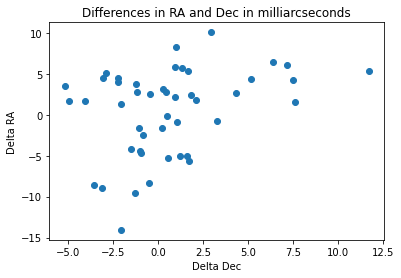

starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits
Image mean, median and std 11.394609 10.827406 55.007805
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 608.5461714111817 2.5131153270429225  0.0008811535076687153   -0.014594743852346248
 685.5165542363047  5.522005289569982      359.9985263490218   -0.014309429398466314
 886.3377102041173  32.12032234845156     359.99243210897583   -0.012997421405947096
  953.858650908105 37.038714754591744     359.99037445698593   -0.012674313169426505
 444.4760693354769 61.921174725845646   0.006066872395400456   -0.013223584608591675
 708.5375051993097  73.05653065791925      359.9979904139565   -0.012224485327696166
 373.6920713251912  82.73362445593573   0.008291490212003361   -0.012772364504572807
 429.1710480615856   96.9361473590585  0.0066252915340002895   -0.012205382067991825
486.33656507950644  111.092996888

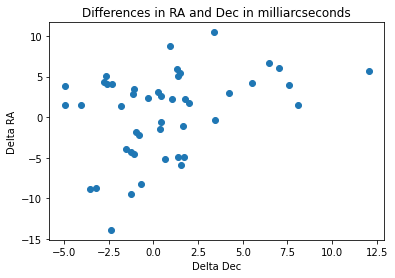

starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.459499 10.829639 55.680965
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
  632.757520509536  43.52799873198921  0.0008804967979520648  -0.014626457969967293
 709.8257801184594 47.507856164720145     359.99852516247785  -0.014311550857858348
 910.5959218383333  74.15073580836673     359.99243330115337  -0.012997209251142885
 978.1734916601412  79.09634950402457     359.99037406382115  -0.012674008968996101
 468.7130887677887 103.70932107395348   0.006068286014852335   -0.01322360404683915
  732.790984782116 114.80235210425441     359.99799208670777  -0.012224549793193257
  397.984710427444 124.51324600589399   0.008291256163280063  -0.012770390494991906
453.48648150451567  138.5482319055374   0.006624203827780067  -0.012205946184055615
 510.5826324979371 152.64448533976542   0.0

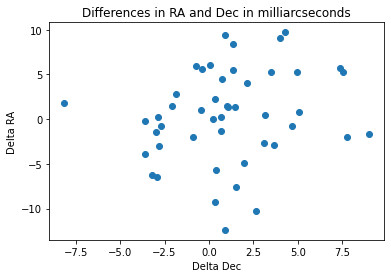

starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits
Image mean, median and std 11.461396 10.8295555 55.684906
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ --------------------- -----------------------
 632.7561014527342  43.52872182023289 0.0010805421836216286     -0.0144264398344063
 709.8260670657803   47.5058809583951     359.9987251486743    -0.01411160945320233
 910.5951520227544  74.15262735916836    359.99263332956474   -0.012797154436724585
 978.1739871993807   79.0963228230719     359.9905740485725   -0.012474008486585366
468.71224848996206 103.70989382247947  0.006268313252319926    -0.01302358882152217
 732.7915923131342 114.80647731539594    359.99819207867637   -0.012024423456819963
397.98413357499743 124.51335799099897  0.008491274137589724    -0.01257038854406763
  453.486222463101  138.5458169269537  0.006824205615986643   -0.012006020134887378
510.58256909558963  152.6453203832899   0.

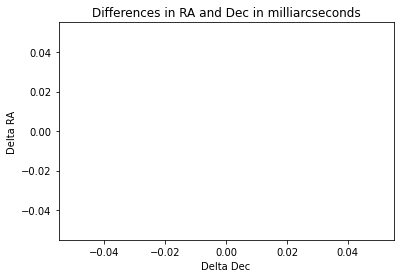

starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.166319 10.819193 52.431835
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 646.9460364189496 123.58824806720995  0.0008803409666353219    -0.01462544759401453
 724.0252320146072  127.5820452764259      359.9985251448545      -0.014310524077353
 924.8606761687124 154.24326052907645      359.9924329361845   -0.012996383566727537
   992.45691902968 159.27374467532363     359.99037339685844   -0.012673064323221303
482.87053476521277 183.28959656865936   0.006068231603246421   -0.013222390879844007
 747.0589422960411 194.39222695244513      359.9979919488258   -0.012223096373398978
412.11218706689084 203.90829274053294   0.008291045403339596   -0.012771385160995604
467.56583952342805 217.90372011464456    0.00662635936109802    -0.01220484372594049
 524.7770858845939 231.8931155015

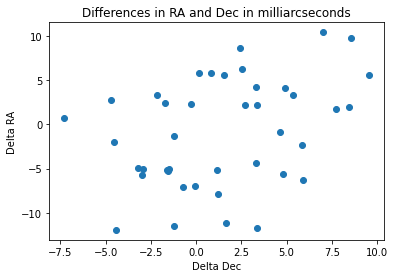

starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits
Image mean, median and std 11.167205 10.820021 52.420555
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
 646.9454800415763 123.59122321380107  0.0008803656879164385  -0.014625358834867506
 724.0256726768248 127.58013796160934      359.9985251264132   -0.01431058074881553
 924.8597080043684  154.2432706124099     359.99243296590157  -0.012996385708730001
 992.4534255006282  159.2718625921307      359.9903734990552  -0.012673130090554478
 482.8696673425391  183.2899835191299   0.006068259202637669  -0.013222381265036554
 747.0578849106864 194.39226082259032      359.9979919813537  -0.012223097981552028
 412.1139269048188 203.90945048821695    0.00829099500464183  -0.012771345469780142
467.56675428766414  217.9036290726527  0.0066263310760417415   -0.01220484420928609
 524.7779965210373 231.88761492892587   0.0

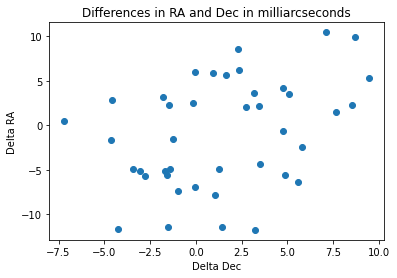

starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits
Image mean, median and std 11.14942 10.819677 52.3238
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 695.2882988999536 103.10651467532003  0.0008800008772832899   -0.014624813910079982
 772.3744183009295  107.0815682195305      359.9985245931245   -0.014309869787115948
  973.228381685913 133.63302595063803     359.99243224223216   -0.012997673379714877
 531.2457880501139 162.90678044840305   0.006067753827247839   -0.013222863142923662
 795.4098654036351 173.99541287004112      359.9979911433319   -0.012223925183360086
  460.547711377863  183.5249036196875   0.008289441834595316   -0.012772358696295038
 515.9706963233565 197.55498823067623   0.006625409028767752   -0.012205661433268716
 573.1045796641623 211.60813499707166   0.004909149394200925    -0.01163371221201762
 899.8933788590772 236.1964594074282

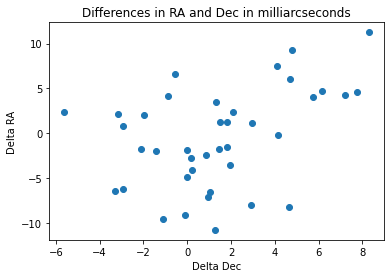

starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits
Image mean, median and std 11.148314 10.819933 52.31703
    xcentroid          ycentroid                RA                    Dec          
------------------ ------------------ ---------------------- ----------------------
   695.28794170584 103.10641319490699  0.0008800115795231863   -0.01462481787900968
 772.3731936505352 107.08007937646431      359.9985246268782  -0.014309917872403828
 973.2281832908834  133.6348268676595       359.992432252969  -0.012997619538201288
 531.2461240972619 162.90616024026545   0.006067741924447004  -0.013222881168460607
 795.4082883628598  173.9964145346605     359.99799119432987   -0.01222389869223297
 460.5482539991836 183.52565213354322   0.008289427105149128  -0.012772334529918135
  515.971022928771 197.55386309448286   0.006625396116303293  -0.012205694933804823
 573.1055169320389  211.6075876893692  0.0049091192277255415  -0.011633726576394846
 899.8952017510751 236.19527724644132     35

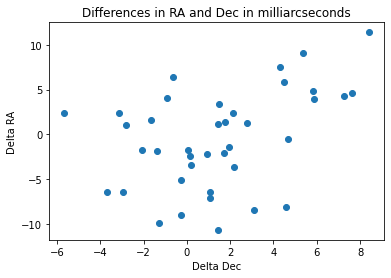

RA difference mean, median and std (units in mas) 1.1084997025612093 0.928302277808206 3.5773131993903524
Dec difference mean, median and std (units in mas) -0.17537865973407207 1.1691161048078824 5.539940734870295


In [23]:
# find stars and get RA, Dec from *_cal.fits files

# Run DAOStarFinder to find sources in image
allRAdiff_cal = []
allDecdiff_cal = []

for calimage in imagelist:
    image = ImageModel(calimage)
    
    # pull out data portion of input file
    data = image.data
    
    # print stats on input image
    print(calimage)
    mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
    print('Image mean, median and std',mean, median, std)

    ap_radius = 5.  # radius for aperture for centroiding and photometry

    daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
    sources = daofind(data)      

    # Create apertures for x,y positions
    positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
    #print(positions)

    #positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = CircularAperture(positions, r=ap_radius)
    
    # using wcs info from images, put coordinates into RA, Dec
    ra, dec = image.meta.wcs(sources['xcentroid'], sources['ycentroid'])

    # add RA, Dec to sources table

    ra_col = Column(name='RA', data=ra)
    dec_col = Column(name='Dec', data=dec)
    sources.add_column(ra_col)
    sources.add_column(dec_col)

    # print RA, Dec for each x, y position found
    #print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

    sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
    sources_sub.pprint_all()
    print()
    
    # read in text file with RA and Dec input coordinates
    RA_in, Dec_in = np.loadtxt(coords, dtype=str, unpack=True)

    # put RA and Dec into floats
    RA_sim = RA_in.astype(float)
    Dec_sim = Dec_in.astype(float)
    
    # Put ra, dec coords into a table
    cat1_sim = Table([RA_sim, Dec_sim], names=('ra', 'dec'))
    cat2_calc = Table([ra, dec], names=('ra', 'dec'))
    

    # Get coordinates with SkyCoord for each catalog
    
    coord_cat1_sim = SkyCoord(ra=cat1_sim['ra'], dec=cat1_sim['dec'], unit="deg")
    coord_cat2_calc = SkyCoord(ra=cat2_calc['ra'], dec=cat2_calc['dec'], unit="deg")
    ind_cat2_cat1, dist_2d, _ = match_coordinates_sky(coord_cat1_sim, coord_cat2_calc)
    
    # Find where the catalogs match
    
    cat1_matched = cat1_sim[dist_2d.arcsec<0.05]
    cat2_matched = cat2_calc[ind_cat2_cat1[dist_2d.arcsec<0.05]]
    
    #print(cat1_matched)
    
    # Get differences in RA, Dec
    ra_diff = cat2_matched['ra'] - cat1_matched['ra']
    dec_diff = cat2_matched['dec'] - cat1_matched['dec'] 
    
    #print(ra_diff)
    
    # put differences in milliarcseconds
    ra_diff = ra_diff * 3600000
    dec_diff = dec_diff * 3600000
    
    
    # Compare input RA, Dec to found RA, Dec
    print('RA_Diff (mas)  Dec_diff (mas) pass/fail')
    # Find if the differences are within the allowed 30 mas range
    for i in np.arange(0,len(ra_diff)):
        #if ra_diff[i] < 30 and dec_diff[i] < 30:
        allRAdiff_cal.append(ra_diff[i])
        allDecdiff_cal.append(dec_diff[i])
        if abs(ra_diff[i]) < 30 and abs(dec_diff[i]) < 30: 
            test = 'pass' 
        else: 
            test = 'fail'
        print('{:15.6f} {:15.6f} {}'.format(ra_diff[i], dec_diff[i], test))
 
    
    # Plot ra and dec differences
    plt.title ('Differences in RA and Dec in milliarcseconds')
    plt.ylabel('Delta RA')
    plt.xlabel('Delta Dec')
    plt.scatter(ra_diff,dec_diff)
    plt.show()

    # Plot should show no differences greater than 30 milliarcseconds  
    
meanRAdiff_cal, medianRAdiff_cal, stdRAdiff_cal = sigma_clipped_stats(allRAdiff_cal, sigma=5.0, maxiters=5)  # default sigma=3
meanDecdiff_cal, medianDecdiff_cal, stdDecdiff_cal = sigma_clipped_stats(allDecdiff_cal, sigma=5.0, maxiters=5)  # default sigma=3

print('RA difference mean, median and std (units in mas)',meanRAdiff_cal, medianRAdiff_cal, stdRAdiff_cal) 
print('Dec difference mean, median and std (units in mas)',meanDecdiff_cal, medianDecdiff_cal, stdDecdiff_cal)

### Run the images through calwebb_image3 with tweakreg on

Alter any parameters needed to get better results from tweakreg. Look at individual i2d images afterwards.

In [24]:
# Run Calwebb_image3 on the association table with tweakreg on
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 3.318 #3.27  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 40 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom ='rshift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
pipe3.tweakreg.save_catalogs = True
#pipe3.tweakreg.skip = True        # test to see if this affects the final output
pipe3.outlier_detection.skip = True
pipe3.source_catalog.save_results = True
pipe3.save_results = True
#pipe3.output_dir = datadir

# run Image3

#im = pipe3.run(rtdata.input)
image = pipe3.run('starfield_50star4ptdither_asnfile.json')
print('Image 3 pipeline finished.')

2021-08-28 02:21:00,917 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2021-08-28 02:21:00,918 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2021-08-28 02:21:00,920 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2021-08-28 02:21:00,921 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2021-08-28 02:21:00,923 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2021-08-28 02:21:00,924 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2021-08-28 02:21:00,926 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2021-08-28 02:21:01,083 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2021-08-28 02:21:01,089 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 40, 'brightest': 

2021-08-28 02:21:01,181 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-08-28 02:21:01,184 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-08-28 02:21:01,186 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-08-28 02:21:01,187 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:21:01,188 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-08-28 02:21:02,080 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-08-28 02:21:02,082 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 40, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-08-28 02:21:02,319 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:21:02,322 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal_cat.ecsv


2021-08-28 02:21:02,588 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:21:02,592 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal_cat.ecsv


2021-08-28 02:21:02,838 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 49 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:21:02,841 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal_cat.ecsv


2021-08-28 02:21:03,109 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:21:03,112 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal_cat.ecsv


2021-08-28 02:21:03,360 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:21:03,363 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal_cat.ecsv


2021-08-28 02:21:03,603 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:21:03,606 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal_cat.ecsv


2021-08-28 02:21:03,856 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 43 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2021-08-28 02:21:03,859 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal_cat.ecsv


2021-08-28 02:21:04,123 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits.


2021-08-28 02:21:04,126 - stpipe.Image3Pipeline.tweakreg - INFO - Wrote source catalog: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal_cat.ecsv


2021-08-28 02:21:04,146 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:04,147 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 8.


2021-08-28 02:21:04,147 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2021-08-28 02:21:04,173 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:21:04,173 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:21:04,198 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:21:04,199 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:21:04,224 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:21:04,224 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:21:04,249 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:21:04,249 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:21:04,273 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:21:04,274 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:21:04,298 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:21:04,298 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:21:04,322 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2021-08-28 02:21:04,322 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2021-08-28 02:21:04,347 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal':


2021-08-28 02:21:04,348 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal


2021-08-28 02:21:04,348 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:04,348 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:21:04,349 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2021-08-28 02:21:04.348956


2021-08-28 02:21:04,349 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.3


2021-08-28 02:21:04,350 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:21:04,499 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2021-08-28 02:21:04,503 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:21:04,604 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:21:04,606 - stpipe.Image3Pipeline.tweakreg - INFO - Found 48 matches for 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:21:04,606 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:21:04,609 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal:


2021-08-28 02:21:04,609 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -4.99872e-05  YSH: -1.34437e-05    ROT: 5.32927e-05    SCALE: 1


2021-08-28 02:21:04,610 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:04,610 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.000287318   FIT MAE: 0.000256544


2021-08-28 02:21:04,611 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 48 objects.


2021-08-28 02:21:04,641 - stpipe.Image3Pipeline.tweakreg - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/wcs.py:1990: DeprecationWarning: Indexing a WCS.pipeline step is deprecated. Use the `frame` and `transform` attributes instead.
  warnings.warn("Indexing a WCS.pipeline step is deprecated. "



2021-08-28 02:21:04,659 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-08-28 02:21:04,759 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:21:04,760 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2021-08-28 02:21:04,761 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:21:04,763 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2021-08-28 02:21:04,763 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000321171  YSH: -4.24579e-05    ROT: -0.000894824    SCALE: 1


2021-08-28 02:21:04,764 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:04,764 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00527931   FIT MAE: 0.00461642


2021-08-28 02:21:04,764 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2021-08-28 02:21:04,802 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:21:04,904 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:21:04,905 - stpipe.Image3Pipeline.tweakreg - INFO - Found 2 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:21:04,906 - stpipe.Image3Pipeline.tweakreg - WARNING - Not enough matches (< 2) found for image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal'.


2021-08-28 02:21:04,906 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-08-28 02:21:05,161 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:21:05,163 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2021-08-28 02:21:05,163 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:21:05,166 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2021-08-28 02:21:05,166 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000303586  YSH: 0.00105847    ROT: -0.000552349    SCALE: 1


2021-08-28 02:21:05,167 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:05,167 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00771548   FIT MAE: 0.00684298


2021-08-28 02:21:05,167 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-08-28 02:21:05,203 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:21:05,307 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:21:05,308 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:21:05,309 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:21:05,311 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal:


2021-08-28 02:21:05,311 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000286148  YSH: 0.00108692    ROT: -0.000523678    SCALE: 1


2021-08-28 02:21:05,312 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:05,312 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00770516   FIT MAE: 0.00682456


2021-08-28 02:21:05,312 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2021-08-28 02:21:05,350 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2021-08-28 02:21:05,448 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:21:05,449 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2021-08-28 02:21:05,450 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:21:05,452 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2021-08-28 02:21:05,453 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000237614  YSH: 0.00262767    ROT: 0.000387146    SCALE: 1


2021-08-28 02:21:05,453 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:05,454 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0110158   FIT MAE: 0.0068922


2021-08-28 02:21:05,454 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-08-28 02:21:05,490 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' to the reference catalog.


2021-08-28 02:21:05,590 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2021-08-28 02:21:05,591 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal'...


2021-08-28 02:21:05,592 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'rshift' fit


2021-08-28 02:21:05,594 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'rshift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal:


2021-08-28 02:21:05,595 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000265638  YSH: 0.00262238    ROT: 0.000458858    SCALE: 1


2021-08-28 02:21:05,595 - stpipe.Image3Pipeline.tweakreg - INFO - 


2021-08-28 02:21:05,595 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0110242   FIT MAE: 0.00691673


2021-08-28 02:21:05,596 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2021-08-28 02:21:05,633 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:21:05,633 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2021-08-28 02:21:05.633309


2021-08-28 02:21:05,634 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:01.284353


2021-08-28 02:21:05,634 - stpipe.Image3Pipeline.tweakreg - INFO -  


2021-08-28 02:21:05,832 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-08-28 02:21:06,005 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-08-28 02:21:06,007 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-08-28 02:21:06,061 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:06,062 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-08-28 02:21:06.061909


2021-08-28 02:21:06,063 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:06,063 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-08-28 02:21:06,064 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-08-28 02:21:06,064 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-08-28 02:21:06,065 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:06,065 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-08-28 02:21:12,769 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00951853


2021-08-28 02:21:12,772 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0215079


2021-08-28 02:21:12,772 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0147932


2021-08-28 02:21:12,773 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.011788


2021-08-28 02:21:12,773 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2021-08-28 02:21:12,773 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00852998


2021-08-28 02:21:12,774 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00325404


2021-08-28 02:21:12,774 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0138587


2021-08-28 02:21:12,774 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:12,775 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-08-28 02:21:12,932 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:12,933 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.81370981910125 [not converted]


2021-08-28 02:21:12,933 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:12,933 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-08-28 02:21:12,934 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8232 (old=0.00951853, delta=10.8137)


2021-08-28 02:21:12,934 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8352 (old=0.0215079, delta=10.8137)


2021-08-28 02:21:12,934 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8285 (old=0.0147932, delta=10.8137)


2021-08-28 02:21:12,935 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8255 (old=0.011788, delta=10.8137)


2021-08-28 02:21:12,935 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8137 (old=0, delta=10.8137)


2021-08-28 02:21:12,935 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8222 (old=0.00852998, delta=10.8137)


2021-08-28 02:21:12,936 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.817 (old=0.00325404, delta=10.8137)


2021-08-28 02:21:12,936 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8276 (old=0.0138587, delta=10.8137)


2021-08-28 02:21:12,936 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:12,936 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-08-28 02:21:12.936648


2021-08-28 02:21:12,937 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:06.874739


2021-08-28 02:21:12,937 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:12,953 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-08-28 02:21:13,113 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-08-28 02:21:13,115 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-08-28 02:21:13,116 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2021-08-28 02:21:13,120 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-08-28 02:21:13,241 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-08-28 02:21:13,243 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:21:13,261 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:21:13,420 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2021-08-28 02:21:13,983 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2021-08-28 02:21:14,600 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:15,762 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:16,896 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:17,863 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:19,002 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:20,227 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:21,359 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:22,534 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:22,988 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:21:23,569 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:24,809 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:25,920 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:26,868 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:27,984 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:29,107 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:30,516 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:31,797 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:32,321 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:21:32,950 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:34,213 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:35,506 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:36,606 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:37,932 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:39,196 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:40,330 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:41,473 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:41,991 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:21:42,550 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:43,714 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:44,867 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:45,961 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:47,179 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:48,376 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:49,550 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:50,764 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:21:51,293 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:21:51,295 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021537904 -0.020352289 0.024611056 0.014667008 359.990573034 0.017654048 359.987499881 -0.017365249


2021-08-28 02:21:51,693 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2021-08-28 02:21:51,694 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-08-28 02:21:51,863 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_50star4ptdither_combined_i2d.fits>,).


2021-08-28 02:21:51,865 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-08-28 02:21:51,881 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-08-28 02:21:51,889 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-08-28 02:21:51,890 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-08-28 02:21:51,890 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-08-28 02:21:51,891 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-08-28 02:21:51,891 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-08-28 02:21:51,928 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-08-28 02:21:52,345 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 610 sources


2021-08-28 02:21:52,981 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2021-08-28 02:21:53,075 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:21:53,076 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:21:53,077 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-08-28 02:21:53,078 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


### Look at positions of RA, Dec and get stats on differences for the combined image run with tweakreg on

In [25]:
im = ImageModel('starfield_50star4ptdither_combined_i2d.fits')
pixarea = im.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea)

# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 2.84403609523084e-13


Image mean, median and std 1.9005519 0.000370268 37.826218


Number of sources found with DAOStarFinder:  49
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 761.9034218558686 130.12749447743613      359.9985243989554   -0.014311642502492767
 962.7812357060434  155.4178641433253     359.99243256095923   -0.012995548307779806
  1030.33695972478 159.93615704564357     359.99037313136023   -0.012675200969398191
 785.0555242512077 196.19719417864707     359.99799223776347   -0.012223319843598411
450.22257741203987 207.71967759630166   0.008290859220838763   -0.012771028941462485
505.71397033768017 221.32514468314523  0.0066258346609064595   -0.012204490013802157
 562.9174697104303 234.93357011350926   0.004908316512523169   -0.011633253030620265
 889.5967771336306 257.18893331378536      359.9949506226865     -0.0100716917311186
 626.9174076352779  266.0772923013419   0.003029574318777771   -0.010506008771245825
 933.537858752740

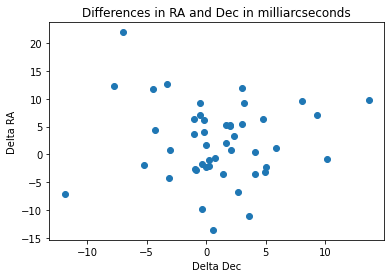


Number of sources matched:  47


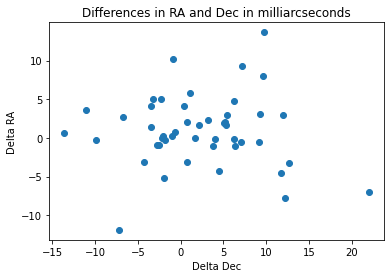

RA difference mean, median and std (units in mas) 0.9477635678665942 0.6031276598150725 4.524781788004206
Dec difference mean, median and std (units in mas) 2.2101685288415434 1.6484057141524788 6.840432904174056


In [26]:
# Run DAOStarFinder to find sources in image

ap_radius = 5.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)

# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

print('Number of sources found with DAOStarFinder: ',np.size(ra))

# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
sources_sub.pprint_all()
print()

# Put ra, dec coords into a table
cat1_sim = Table([RA_sim, Dec_sim], names=('ra', 'dec'))
cat2_calc = Table([ra, dec], names=('ra', 'dec'))
    
# Get coordinates with SkyCoord for each catalog
    
coord_cat1_sim = SkyCoord(ra=cat1_sim['ra'], dec=cat1_sim['dec'], unit="deg")
coord_cat2_calc = SkyCoord(ra=cat2_calc['ra'], dec=cat2_calc['dec'], unit="deg")    
ind_cat2_cat1, dist_2d, _ = match_coordinates_sky(coord_cat1_sim, coord_cat2_calc)
    
# Find where the catalogs match
    
cat1_matched = cat1_sim[dist_2d.arcsec<0.05]
cat2_matched = cat2_calc[ind_cat2_cat1[dist_2d.arcsec<0.05]]
    
#print(cat1_matched)
    
# Get differences in RA, Dec
ra_diff = cat2_matched['ra'] - cat1_matched['ra']
dec_diff = cat2_matched['dec'] - cat1_matched['dec'] 
    
#print(ra_diff)
    
# put differences in milliarcseconds
ra_diff = ra_diff * 3600000
dec_diff = dec_diff * 3600000

deltara_twon = []
deltadec_twon = []
    
# Compare input RA, Dec to found RA, Dec
print('RA_Diff (mas)  Dec_diff (mas) pass/fail')
# Find if the differences are within the allowed 30 mas range
for i in np.arange(0,len(ra_diff)):
    #if ra_diff[i] < 30 and dec_diff[i] < 30:
    deltara_twon.append(ra_diff[i])
    deltadec_twon.append(dec_diff[i])
    if abs(ra_diff[i]) < 30 and abs(dec_diff[i]) < 30: 
        test = 'pass' 
    else: 
        test = 'fail'
    print('{:15.6f} {:15.6f} {}'.format(ra_diff[i], dec_diff[i], test))
 
    
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in milliarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltara_twon,deltadec_twon)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds  

print()
print('Number of sources matched: ', np.size(deltara_twon))
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in milliarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltadec_twon,deltara_twon)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds      

    
meanRAdiff_twon, medianRAdiff_twon, stdRAdiff_twon = sigma_clipped_stats(deltara_twon, sigma=5.0, maxiters=5)  # default sigma=3
meanDecdiff_twon, medianDecdiff_twon, stdDecdiff_twon = sigma_clipped_stats(deltadec_twon, sigma=5.0, maxiters=5)  # default sigma=3

print('RA difference mean, median and std (units in mas)',meanRAdiff_twon, medianRAdiff_twon, stdRAdiff_twon) 
print('Dec difference mean, median and std (units in mas)',meanDecdiff_twon, medianDecdiff_twon, stdDecdiff_twon)

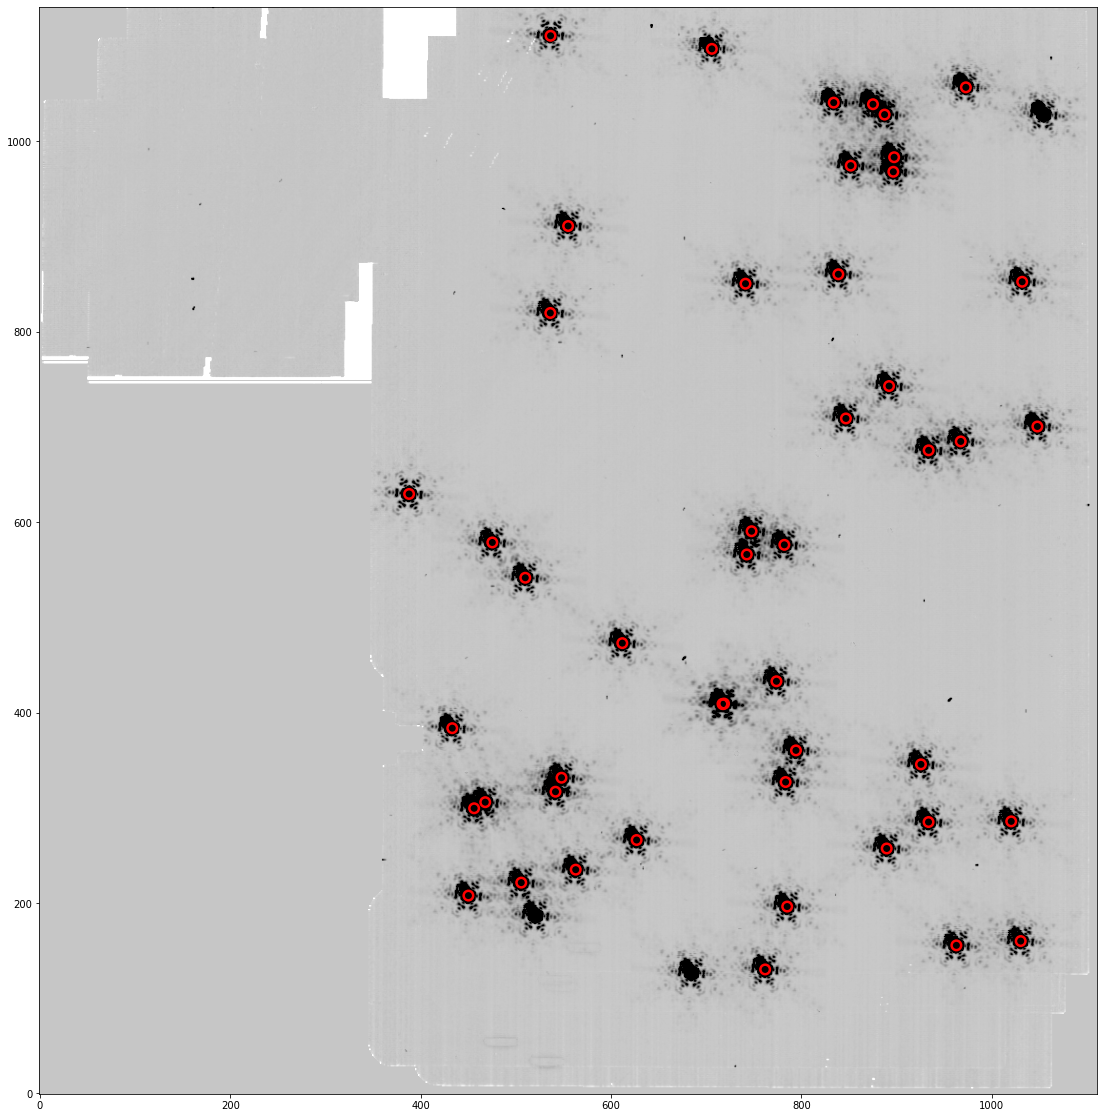

In [27]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='Greys', origin='lower', vmin=-5,vmax=10)#, norm=norm)
apertures.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

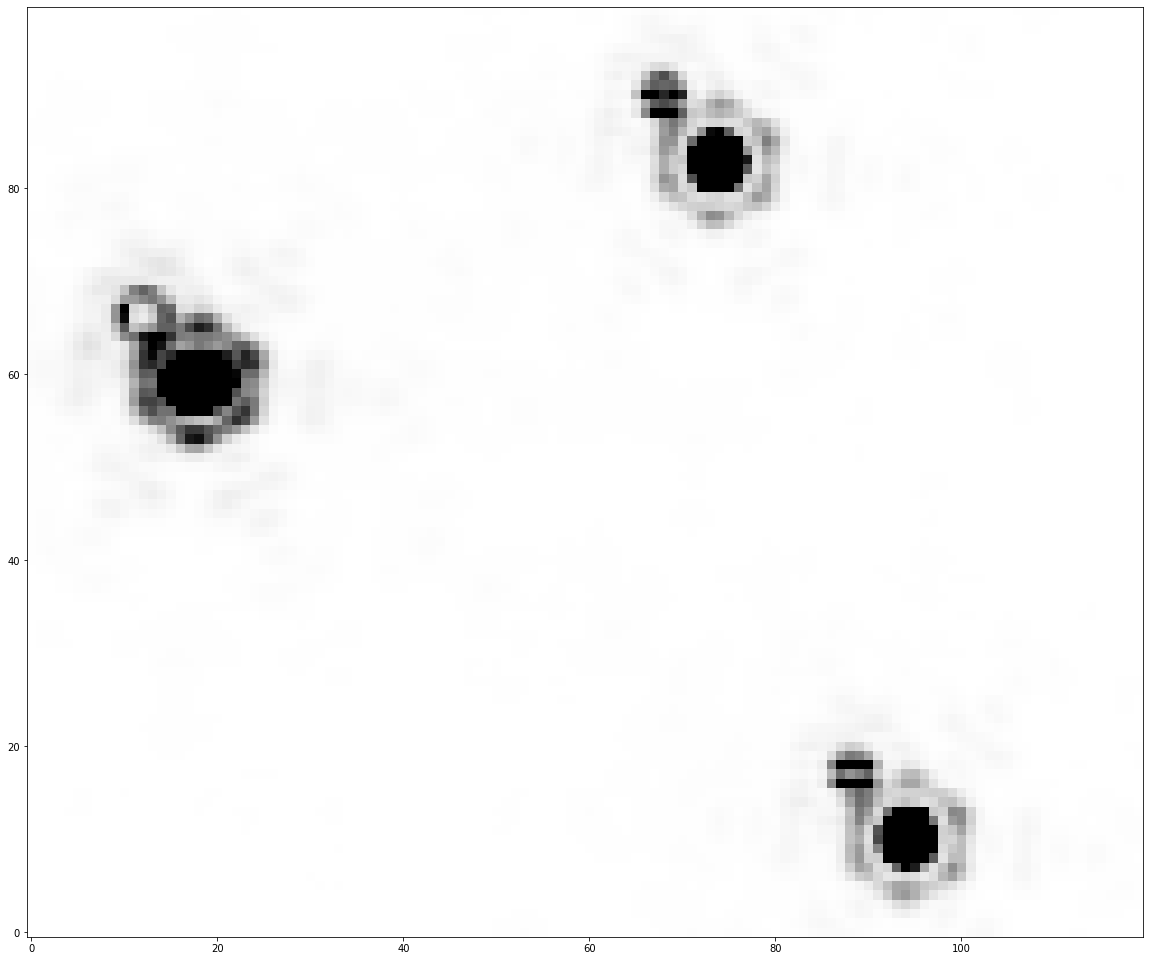

In [28]:
# Take a closer look at a portion of the image to get a closer look at the psf

# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))

plt.imshow(data[350:450, 700:820], cmap='Greys', origin='lower', vmin=0,vmax=200)#, norm=norm)
#apertures.plot(color='red', lw=2.5) #, alpha=0.5)
#plt.scatter(sources['xcentroid']-700, sources['ycentroid']-350, color='red')
#plt.ylim(350,450)
#plt.xlim(700,820)
plt.show()

### Test again with tweakreg off

In [29]:
# Run Calwebb_image3 on the association table with tweakreg on
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm = 3.318 #3.27  # Gaussian kernel FWHM of objects expected, default=2.5
minobj = 5  # minimum number of objects needed to match positions for a good fit, default=15
snr = 40 # signal to noise threshold, default=5
sigma = 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom ='rshift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist = False  # boolean indicating whether to use 2D histogram to find initial offset, default=True
   
#pipe3=Image3Pipeline()    
#pipe3.tweakreg.kernel_fwhm = fwhm
#pipe3.tweakreg.snr_threshold = snr
#pipe3.tweakreg.minobj = minobj
#pipe3.tweakreg.sigma = sigma
#pipe3.tweakreg.fitgeometry = fit_geom
#pipe3.tweakreg.use2dhist = use2dhist
pipe3.tweakreg.skip = True        # test to see if this affects the final output
pipe3.outlier_detection.skip = True
pipe3.source_catalog.save_results = True
pipe3.save_results = True
#pipe3.output_dir = datadir

# run Image3

#im = pipe3.run(rtdata.input)
image = pipe3.run('starfield_50star4ptdither_asnfile.json')
print('Image 3 pipeline finished.')

2021-08-28 02:21:54,772 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2021-08-28 02:21:54,778 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpakjgxx4l/starfield_50star4ptdither_combined.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'image3pipeline', 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'tweakreg', 'sea

2021-08-28 02:21:54,870 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2021-08-28 02:21:54,873 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2021-08-28 02:21:54,875 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2021-08-28 02:21:54,876 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2021-08-28 02:21:54,877 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2021-08-28 02:21:55,791 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2021-08-28 02:21:55,793 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': 'tweakreg', 'search_output_file': True, 'input_dir': '', 'save_catalogs': True, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.318, 'snr_threshold': 40, 'brightest': 1000, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 1.0, 'use2dhist': False, 'separation': 0.5, 'tolerance': 1.0, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2021-08-28 02:21:55,794 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2021-08-28 02:21:55,798 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2021-08-28 02:21:55,924 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2021-08-28 02:21:55,926 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'skymatch', 'search_output_file': True, 'input_dir': '', 'skymethod': 'global+match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '0', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2021-08-28 02:21:56,014 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:56,015 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2021-08-28 02:21:56.014886


2021-08-28 02:21:56,016 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:56,016 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'global+match'


2021-08-28 02:21:56,016 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2021-08-28 02:21:56,017 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2021-08-28 02:21:56,017 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:21:56,017 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2021-08-28 02:22:02,738 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00951853


2021-08-28 02:22:02,740 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0215079


2021-08-28 02:22:02,741 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0147932


2021-08-28 02:22:02,741 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.011788


2021-08-28 02:22:02,741 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2021-08-28 02:22:02,742 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.00852998


2021-08-28 02:22:02,742 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00325404


2021-08-28 02:22:02,742 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 0.0138587


2021-08-28 02:22:02,743 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:22:02,743 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing "global" sky - smallest sky value across *all* input images.


2021-08-28 02:22:02,901 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:22:02,902 - stpipe.Image3Pipeline.skymatch - INFO -    "Global" sky value correction: 10.81370981910125 [not converted]


2021-08-28 02:22:02,902 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:22:02,902 - stpipe.Image3Pipeline.skymatch - INFO - ----  Final (match+global) sky for:


2021-08-28 02:22:02,903 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8232 (old=0.00951853, delta=10.8137)


2021-08-28 02:22:02,903 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8352 (old=0.0215079, delta=10.8137)


2021-08-28 02:22:02,903 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8285 (old=0.0147932, delta=10.8137)


2021-08-28 02:22:02,904 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8255 (old=0.011788, delta=10.8137)


2021-08-28 02:22:02,904 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.8137 (old=0, delta=10.8137)


2021-08-28 02:22:02,904 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8222 (old=0.00852998, delta=10.8137)


2021-08-28 02:22:02,905 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 10.817 (old=0.00325404, delta=10.8137)


2021-08-28 02:22:02,906 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp2_cal.fits. Sky background: 10.8276 (old=0.0138587, delta=10.8137)


2021-08-28 02:22:02,906 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:22:02,906 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2021-08-28 02:22:02.906347


2021-08-28 02:22:02,907 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:06.891461


2021-08-28 02:22:02,907 - stpipe.Image3Pipeline.skymatch - INFO -  


2021-08-28 02:22:02,921 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2021-08-28 02:22:03,067 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2021-08-28 02:22:03,069 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2021-08-28 02:22:03,070 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2021-08-28 02:22:03,075 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2021-08-28 02:22:03,201 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2021-08-28 02:22:03,202 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'pixel_scale_ratio': 1.0, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2021-08-28 02:22:03,217 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2021-08-28 02:22:03,364 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2021-08-28 02:22:03,933 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2021-08-28 02:22:04,571 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:05,650 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:06,679 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:07,695 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:08,712 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:09,741 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:10,755 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:11,752 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:12,171 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2021-08-28 02:22:12,745 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:13,733 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:14,696 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:15,669 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:16,634 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:17,589 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:18,526 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:19,481 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:19,983 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2021-08-28 02:22:20,527 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:21,487 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:22,461 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:23,418 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:24,391 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:25,361 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:26,340 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:27,326 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:27,820 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2021-08-28 02:22:28,371 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:29,327 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:30,294 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:31,284 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:32,281 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:33,264 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:34,253 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:35,220 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1111)


2021-08-28 02:22:35,746 - stpipe.Image3Pipeline.resample - WARNING - /data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.8/site-packages/gwcs/utils.py:72: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indx = np.asarray(np.floor(np.asarray(value) + 0.5), dtype=np.int)



2021-08-28 02:22:35,748 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021538048 -0.020352659 0.024611201 0.014666639 359.990573179 0.017653679 359.987500025 -0.017365618


2021-08-28 02:22:36,137 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2021-08-28 02:22:36,138 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2021-08-28 02:22:36,309 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1111) from starfield_50star4ptdither_combined_i2d.fits>,).


2021-08-28 02:22:36,311 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 2.0, 'snr_threshold': 3.0, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2021-08-28 02:22:36,330 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2021-08-28 02:22:36,339 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2021-08-28 02:22:36,340 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2021-08-28 02:22:36,340 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2021-08-28 02:22:36,340 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2021-08-28 02:22:36,341 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2021-08-28 02:22:36,378 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2021-08-28 02:22:36,804 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 611 sources


2021-08-28 02:22:37,462 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2021-08-28 02:22:37,556 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:22:37,558 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_segm.fits


2021-08-28 02:22:37,559 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2021-08-28 02:22:37,561 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


In [30]:
im = ImageModel('starfield_50star4ptdither_combined_i2d.fits')
pixarea = im.meta.photometry.pixelarea_steradians
print('Pixel area in steradians', pixarea)

# pull out data portion of input file
data = im.data

# print stats on input image
mean, median, std = sigma_clipped_stats(data, sigma=200.0, maxiters=5)  # default sigma=3
print('Image mean, median and std',mean, median, std)

Pixel area in steradians 2.84403609523084e-13


Image mean, median and std 1.900452 0.0003435266 37.81957


Number of sources found with DAOStarFinder:  49
    xcentroid          ycentroid                RA                     Dec          
------------------ ------------------ ---------------------- -----------------------
 761.9078337423421  130.1264254379855      359.9985244052114   -0.014312032735781766
 962.7858827276198  155.4183882791338     359.99243256429213   -0.012995889053763003
 1030.343897358478  159.9429902548902      359.9903730814297   -0.012675342084260322
  785.059506830892  196.2016158923697     359.99799227195996   -0.012223542858829086
 450.2271051319359 207.72048270405833   0.008290866968237675   -0.012771361392530083
 505.7180073007121   221.331058817925   0.006625871205838033   -0.012204667117782574
 562.9212207664362 234.93519405724692  0.0049083502797376485   -0.011633562462194297
 889.6010835851372 257.19350498697577       359.994950647355   -0.010071909276316656
 626.9212321661056 266.08061400207464  0.0030296104016064363   -0.010506265943568705
 933.542428950714

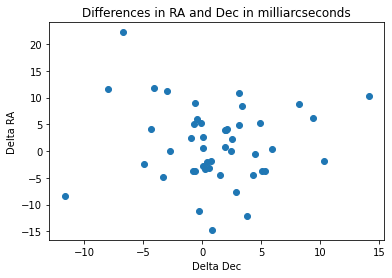


RA difference mean, median and std (units in mas) 1.1025910582539042 0.7711923899478279 4.558606238987361
Dec difference mean, median and std (units in mas) 1.2979159999883456 0.5125128701370663 7.0084952522135


In [31]:
# Run DAOStarFinder to find sources in image

ap_radius = 5.  # radius for aperture for centroiding and photometry

daofind = DAOStarFinder(fwhm=3.0, threshold=10.*std)    # default threshold=5*std, fwhm=3
sources = daofind(data)    

#sources.pprint_all()
#print(sources['xcentroid','ycentroid','peak'])   

# Create apertures for x,y positions
positions = tuple(zip(sources['xcentroid'], sources['ycentroid']))
#print(positions)

#positions = (sources['xcentroid'], sources['ycentroid'])
apertures = CircularAperture(positions, r=ap_radius)


# using wcs info from images, put coordinates into RA, Dec
ra, dec = im.meta.wcs(sources['xcentroid'], sources['ycentroid'])

print('Number of sources found with DAOStarFinder: ',np.size(ra))
# add RA, Dec to sources table

ra_col = Column(name='RA', data=ra)
dec_col = Column(name='Dec', data=dec)
sources.add_column(ra_col)
sources.add_column(dec_col)

# print RA, Dec for each x, y position found
#print(sources['xcentroid', 'ycentroid', 'RA', 'Dec'])  

sources_sub = sources['xcentroid', 'ycentroid', 'RA', 'Dec']
sources_sub.pprint_all()
print()

# Compare input RA, Dec to found RA, Dec
#print('       RA found       Dec found    RA_Diff (mas)  Dec_diff (mas) pass/fail')

deltara_twoff = []
deltadec_twoff = []

# Put ra, dec coords into a table
cat1_sim = Table([RA_sim, Dec_sim], names=('ra', 'dec'))
cat2_calc = Table([ra, dec], names=('ra', 'dec'))
    
# Get coordinates with SkyCoord for each catalog
    
coord_cat1_sim = SkyCoord(ra=cat1_sim['ra'], dec=cat1_sim['dec'], unit="deg")
coord_cat2_calc = SkyCoord(ra=cat2_calc['ra'], dec=cat2_calc['dec'], unit="deg")    
ind_cat2_cat1, dist_2d, _ = match_coordinates_sky(coord_cat1_sim, coord_cat2_calc)
    
# Find where the catalogs match
    
cat1_matched = cat1_sim[dist_2d.arcsec<0.05]
cat2_matched = cat2_calc[ind_cat2_cat1[dist_2d.arcsec<0.05]]
    
#print(cat1_matched)
    
# Get differences in RA, Dec
ra_diff = cat2_matched['ra'] - cat1_matched['ra']
dec_diff = cat2_matched['dec'] - cat1_matched['dec'] 
    
#print(ra_diff)
    
# put differences in milliarcseconds
ra_diff = ra_diff * 3600000
dec_diff = dec_diff * 3600000

    
# Compare input RA, Dec to found RA, Dec
print('RA_Diff (mas)  Dec_diff (mas) pass/fail')
# Find if the differences are within the allowed 30 mas range
for i in np.arange(0,len(ra_diff)):
    #if ra_diff[i] < 30 and dec_diff[i] < 30:
    deltara_twoff.append(ra_diff[i])
    deltadec_twoff.append(dec_diff[i])
    if abs(ra_diff[i]) < 30 and abs(dec_diff[i]) < 30: 
        test = 'pass' 
    else: 
        test = 'fail'
    print('{:15.6f} {:15.6f} {}'.format(ra_diff[i], dec_diff[i], test))
 
    
# Plot ra and dec differences
plt.title ('Differences in RA and Dec in milliarcseconds')
plt.ylabel('Delta RA')
plt.xlabel('Delta Dec')
plt.scatter(deltara_twoff,deltadec_twoff)
plt.show()

# Plot should show no differences greater than 30 milliarcseconds 

print()
    
meanRAdiff_twoff, medianRAdiff_twoff, stdRAdiff_twoff = sigma_clipped_stats(deltara_twoff, sigma=5.0, maxiters=5)  # default sigma=3
meanDecdiff_twoff, medianDecdiff_twoff, stdDecdiff_twoff = sigma_clipped_stats(deltadec_twoff, sigma=5.0, maxiters=5)  # default sigma=3

print('RA difference mean, median and std (units in mas)',meanRAdiff_twoff, medianRAdiff_twoff, stdRAdiff_twoff) 
print('Dec difference mean, median and std (units in mas)',meanDecdiff_twoff, medianDecdiff_twoff, stdDecdiff_twoff)

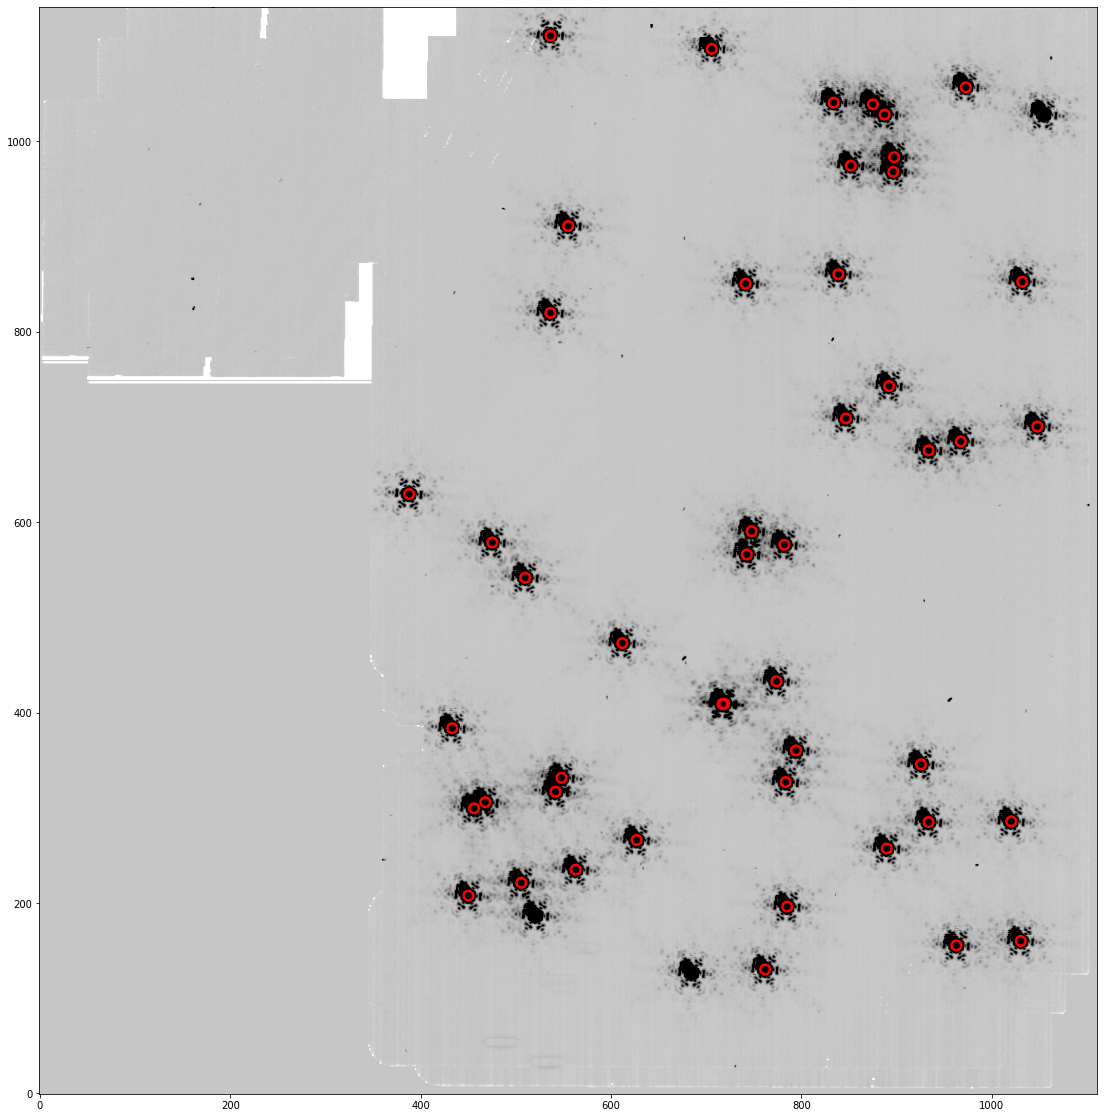

In [32]:
# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))
plt.imshow(data, cmap='Greys', origin='lower', vmin=-5,vmax=10)#, norm=norm)
apertures.plot(color='red', lw=2.5) #, alpha=0.5)
plt.show()

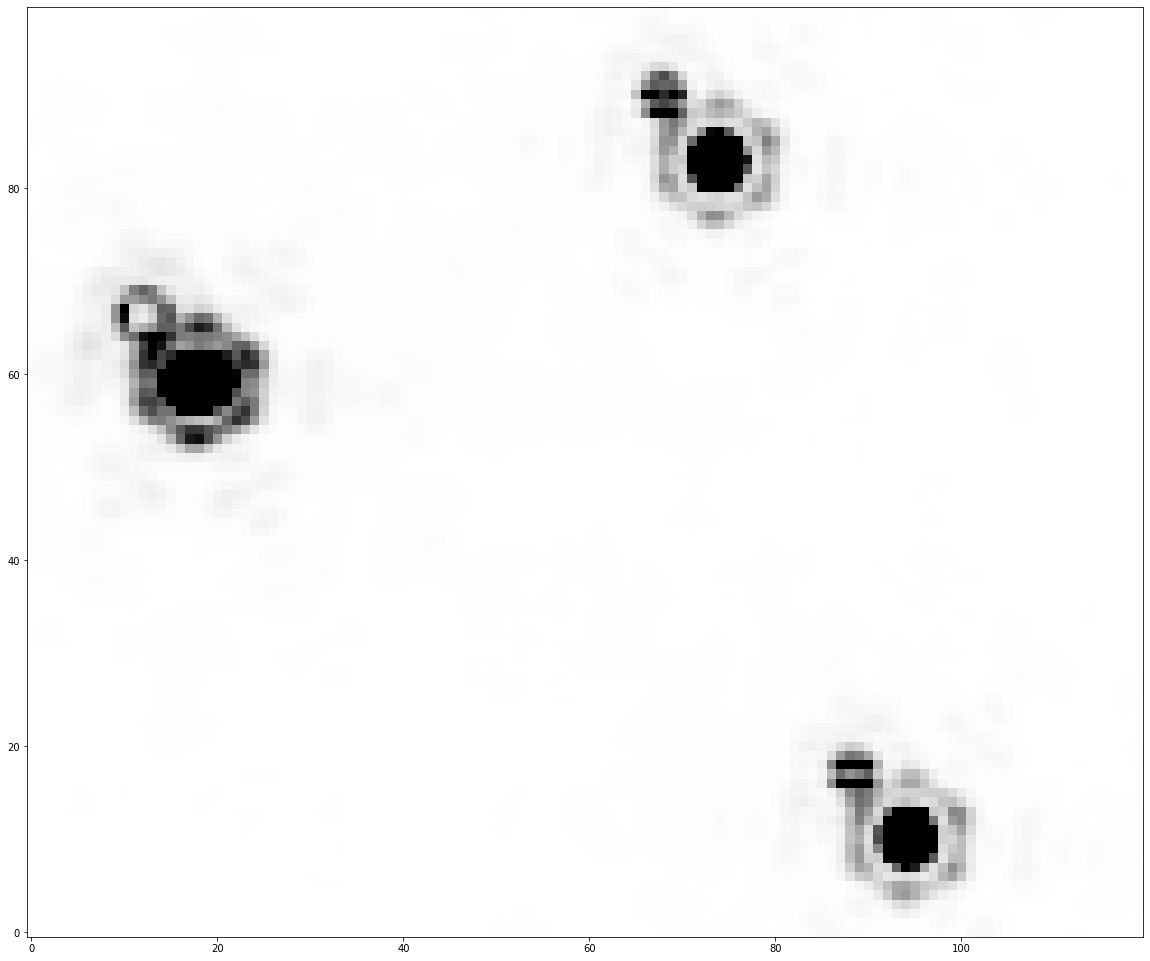

In [33]:
# Take a closer look at a portion of the image to get a closer look at the psf

# mark sources on image frame to see if the correct sources were found
norm = ImageNormalize(stretch=SqrtStretch())
# keep image stretch in mind for plotting. sky subtracted range ~ (-15, 10), single sample ~ (0, 20)
plt.figure(figsize=(20,20))

plt.imshow(data[350:450, 700:820], cmap='Greys', origin='lower', vmin=0,vmax=200)#, norm=norm)

#plt.scatter(sources['xcentroid']-700, sources['ycentroid']-350, color='red')

plt.show()

In [34]:
# Compare stats across tests:
print('All units are milliarcseconds for statistics')
print('Statistics on differences between RA and Dec in individual calibrated files')
print('RA difference mean, median and std',meanRAdiff_cal, medianRAdiff_cal, stdRAdiff_cal) 
print('Dec difference mean, median and std',meanDecdiff_cal, medianDecdiff_cal, stdDecdiff_cal)
print()
#print('Statistics on differences between RA and Dec in individual i2d files when run with tweakreg on')
#print('RA difference mean, median and std',meanRAdiff_i2d, medianRAdiff_i2d, stdRAdiff_i2d) 
#print('Dec difference mean, median and std',meanDecdiff_i2d, medianDecdiff_i2d, stdDecdiff_i2d)
#print()
print('Statistics on differences between RA and Dec in combined i2d file when run with tweakreg on')
print('RA difference mean, median and std',meanRAdiff_twon, medianRAdiff_twon, stdRAdiff_twon) 
print('Dec difference mean, median and std',meanDecdiff_twon, medianDecdiff_twon, stdDecdiff_twon)
print()
print('Statistics on differences between RA and Dec in combined i2d file when run with tweakreg off')
print('RA difference mean, median and std',meanRAdiff_twoff, medianRAdiff_twoff, stdRAdiff_twoff) 
print('Dec difference mean, median and std',meanDecdiff_twoff, medianDecdiff_twoff, stdDecdiff_twoff)

All units are milliarcseconds for statistics
Statistics on differences between RA and Dec in individual calibrated files
RA difference mean, median and std 1.1084997025612093 0.928302277808206 3.5773131993903524
Dec difference mean, median and std -0.17537865973407207 1.1691161048078824 5.539940734870295

Statistics on differences between RA and Dec in combined i2d file when run with tweakreg on
RA difference mean, median and std 0.9477635678665942 0.6031276598150725 4.524781788004206
Dec difference mean, median and std 2.2101685288415434 1.6484057141524788 6.840432904174056

Statistics on differences between RA and Dec in combined i2d file when run with tweakreg off
RA difference mean, median and std 1.1025910582539042 0.7711923899478279 4.558606238987361
Dec difference mean, median and std 1.2979159999883456 0.5125128701370663 7.0084952522135


### Criteria for success.

If the first set of images with no shift are well aligned as shown in images and the statistical comparison, that test passes.

Once a shift is added, the statistics and number of sources found don't tell the whole story. Look at the combined images shown after image3 with and without tweakreg. If the image run with tweakreg shows double sources just like the image without tweakreg, then the test fails. If the image doesn't show double sources and looks like the unshifted combined image, then the test passes. Examine the image to look for obvious faults like stars that were not identified as stars, those with multiple star identifications, double star images, etc.

#### About this Notebook

Authors: M. Cracraft, M. Libralato and K. Gordon, MIRI Branch

Updated On: 08/25/2021